# Last Away ~ Coherence: SLCH002

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import mne_connectivity
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [2]:
## Prep paths ##

subject = 'SLCH002'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [3]:
## Load Neural Data

# load
last_away_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")

# get good epochs (for behavioral data only)
good_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if not x]
bad_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if  x]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")

# set info as metadata
last_away_epochs.metadata = last_away_data

# onlt good epochs
last_away_epochs = last_away_epochs[good_epochs]

Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif ...


/tmp/ipykernel_4138831/1924150984.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_epochs = mne.read_epochs(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif")


    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Reading /home/brooke/pacman/preprocessing/SLCH002/ieeg/SLCH002_bp_raw_clean_last_away_events-1.fif ...
    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns


In [4]:
## Dictionary of electrode locations ##

# Dictionary mapping ROI to elecs
ROIs = {
    'hc'     :['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'K7'],
    'ofc'    :['A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B5', 'B6', 'B7', 'B8', 'B9'],
    'amyg'   :['i1', 'i2', 'i3', 'i4', 'i5'],
    'insula' :['C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'E2', 'E3', 'E4', 'F1', 'F2', 'F3'],
    'cing'   :['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4'],
    'ec'     :['H1', 'H2', 'H3', 'H4', 'L1', 'L2', 'L3', 'L4'], 
    'dlpfc'  :['C11', 'C12', 'C13', 'C14', 'C15', 'C16'] 
}

## prep lists

# primary ROI
hc_list = []
hc_indices = []
hc_names = []
ofc_list = []
ofc_indices = []
ofc_names = []
amyg_list = []
amyg_names = [] 
amyg_indices = []
cing_list = []
cing_names = [] 
cing_indices = []

# control ROI
insula_list = []
insula_names = []  
insula_indices = []
dlpfc_list = []
dlpfc_names = []  
dlpfc_indices = []
ec_list = []
ec_names = []  
ec_indices = []

# exclude bad ROI from list
pairs_long_name = [ch.split('-') for ch in last_away_epochs.info['ch_names']]
bidx = len(last_away_epochs.info['bads']) +1
pairs_name = pairs_long_name[bidx:len(pairs_long_name)]

# sort ROI into lists
for ix in range(0, len(pairs_name)):
    if pairs_name[ix][0] in ROIs['hc'] or pairs_name[ix][1] in ROIs['hc']:
        hc_list.append(last_away_epochs.info['ch_names'][ix + bidx])
        hc_names.append(pairs_name[ix])
        hc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ofc'] or pairs_name[ix][1] in ROIs['ofc']:
        ofc_list.append(last_away_epochs.info['ch_names'][ix + bidx])
        ofc_names.append(pairs_name[ix])
        ofc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['amyg'] or pairs_name[ix][1] in ROIs['amyg']:
        amyg_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        amyg_names.append(pairs_name[ix])
        amyg_indices.append(ix)
    if pairs_name[ix][0] in ROIs['cing'] or pairs_name[ix][1] in ROIs['cing']:
        cing_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        cing_names.append(pairs_name[ix])
        cing_indices.append(ix)
        
    # control roi
    if pairs_name[ix][0] in ROIs['insula'] or pairs_name[ix][1] in ROIs['insula']:
        insula_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        insula_names.append(pairs_name[ix])
        insula_indices.append(ix)
    if pairs_name[ix][0] in ROIs['dlpfc'] or pairs_name[ix][1] in ROIs['dlpfc']:
        dlpfc_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        dlpfc_names.append(pairs_name[ix])
        dlpfc_indices.append(ix)
    if pairs_name[ix][0] in ROIs['ec'] or pairs_name[ix][1] in ROIs['ec']:
        ec_list.append(last_away_epochs.info['ch_names'][ix + bidx])       
        ec_names.append(pairs_name[ix])
        ec_indices.append(ix)        
        

In [5]:
## funcions

def compute_coherence(epochs, ch_names, roi_index, freqs, n_cycles,  workers = 8):
    """ function to compute TFR via Morlet wavelets
    
    epochs:                     MNE epoch object with channels of interest
    freqs:                      list of frequencies, should be log spaced
    n_cycles:                   number of cycles, adjust with freqs to balance temporal and frequency resolution
    workers:                    number of threads to use while calculating TFR
    """
    print('computing TFR')
    connect = mne_connectivity.spectral_connectivity_epochs(data = epochs,
                                                            names = ch_names,
                                                            method = ['coh', 'cohy', 'imcoh', 'plv', 'ciplv', 'ppc', 'pli', 'dpli', 'wpli', 'wpli2_debiased'],
                                                            mode = 'cwt_morlet',
                                                            cwt_freqs = freqs,
                                                            cwt_n_cycles = n_cycles,
                                                            n_jobs = workers)

    return connect

def extract_freqs(lower_freq, higher_freq, freq_band, subdir, ROI, label, TFR, trials):
    """ function to extract and average the across the freqs within a given band and save out to csvs
    step is calculated based on getting ~4 samples per frequency cycle
    
    lower_freq, higher_freq:    non inclusive lower and upper bounds of the band
    freq_band:                  band name, as a string
    subdir:                     dir in sub/ieeg/ that specifies the time locking
    ROI:                        region name, as a string
    label:                      label, eg ghost, no ghost, choice locked etc, as a string
    TFR:                        MNE TFR object
    """
    
    # calculate step, ## note I made this up, but it seems reasonable?
    step = {
        'delta'      : int(np.floor(TFR.info['sfreq']/(2*4))),
        'theta'      : int(np.floor(TFR.info['sfreq']/(5*4))),
        'alpha'      : int(np.floor(TFR.info['sfreq']/(11*4))),
        'beta'       : int(np.floor(TFR.info['sfreq']/(22*4))),
        'gamma'      : int(np.floor(TFR.info['sfreq']/(50*4))),
        'hfa'        : int(np.floor(TFR.info['sfreq']/(110*4)))
    }
    
    # check if it needs to be calculated with subbands
    if freq_band == 'gamma' or freq_band == 'hfa':
        
        if TFR.info['sfreq'] < 1000:
                                raise Exception('Sampling Rate is below 1000, should calculate gamma or HFA') 
        
        subband_dict = {
            'gamma'    : [(30, 40), (35, 45), (40, 50), (45, 55), (50, 60), (55, 65), (60, 70)],
            'hfa'      : [(70, 90), (80, 100), (90, 110), (100, 120), (110, 130), (120, 140), (130, 150)]
        }
        
        for chix in range(len(TFR.ch_names)):
            subb_trial_power = []
            for subb in subband_dict[freq_band]:
                fidx = np.where((freqs > subb[0]) & (freqs < subb[1]))[0]
                subb_trial_power.append(TFR.data[:, chix, fidx, :].mean(axis=1))
            trial_power = np.mean(subb_trial_power, axis = 0)
            channel_df = pd.DataFrame(trial_power[:, ::step[freq_band]])
            channel_df["trial"] = trials
            channel_df.to_csv(f"{preproc_data_dir}/{subdir}/{TFR.ch_names[chix]}_{ROI}_trial_{freq_band}_{label}.csv")
    
    else:
        fidx = np.where((freqs > lower_freq) & (freqs < higher_freq))[0]
        for chix in range(len(TFR.ch_names)):
            trial_power = TFR.data[:, chix, fidx, :].mean(axis=1)
            channel_df = pd.DataFrame(trial_power[:, ::step[freq_band]])
            channel_df["trial"] = trials
            channel_df.to_csv(f"{preproc_data_dir}/{subdir}/{TFR.ch_names[chix]}_{ROI}_trial_{freq_band}_{label}.csv")

In [6]:
# Set frequencies

freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
n_cycles = np.logspace(np.log10(2), np.log10(30), base = 10, num = 80)

# formulas to check bandwidth and time bin
band_width = (freqs / n_cycles) * 2
time_bin = n_cycles / freqs / np.pi
print(freqs)
print(n_cycles)
print(time_bin)
print(band_width)


[  1.           1.06548039   1.13524845   1.20958496   1.28878905
   1.37317945   1.46309577   1.55889984   1.6609772    1.76973863
   1.8856218    2.00909304   2.14064922   2.28081976   2.43016872
   2.5892971    2.75884527   2.93949552   3.13197482   3.33705774
   3.55556956   3.78838962   4.03645484   4.30076345   4.5823791
   4.88243505   5.20213877   5.54277682   5.90571998   6.2924288
   6.70445946   7.14347005   7.61122722   8.10961331   8.64063391
   9.20642595   9.80926626  10.45158079  11.13595433  11.8651409
  12.6420749   13.46988283  14.35189595  15.29166362  16.29296764
  17.35983743  18.49656627  19.70772855  20.99819821  22.37316831
  23.83817199  25.39910467  27.06224782  28.83429423  30.72237491
  32.73408785  34.87752853  37.16132253  39.59466023  42.18733383
  44.94977669  47.89310538  51.02916436  54.37057369  57.93077979
  61.72410955  65.76582801  70.07219975  74.66055437  79.54935622
  84.75827869  90.30828341  96.22170458 102.52233885 109.23554107
 116.38832636

# Main Regions of Interest

## Hippocampus

In [7]:
test_list = ['J6-J7', 'K1-K2', 'K7-K8', 'C10-C11', 'C12-C13', 'C15-C16']
test_list

['J6-J7', 'K1-K2', 'K7-K8', 'C10-C11', 'C12-C13', 'C15-C16']

In [8]:
last_away_epochs

<EpochsFIF |  170 events (all good), -5 - 5 sec, baseline off, ~4.18 GB, data loaded, with metadata,
 '1': 170>

In [9]:
# only ROI of interest
last_away_roi = last_away_epochs.copy().pick_channels(test_list)


In [10]:
last_away_roi.info.ch_names

['C10-C11', 'C12-C13', 'C15-C16', 'J6-J7', 'K1-K2', 'K7-K8']

In [11]:
# Resample to 1000 
if last_away_roi.info['sfreq'] > 1000:
    last_away_roi= last_away_roi.resample(1000)

In [12]:
# compute TRF

roi_coherence = []
roi_coherence = compute_coherence(last_away_roi, test_list, 'all', freqs, n_cycles, workers = 8)


computing TFR
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 15 connections
    using t=-5.000s..4.999s for estimation (10000 points)
    frequencies: 1.0Hz..150.0Hz (80 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence, Coherency, Imaginary Coherence, PLV, ciPLV, PPC, PLI, DPLI, WPLI, Debiased WPLI Square
    computing connectivity for epochs 1..8


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   20.6s remaining:   34.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   26.4s remaining:   15.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   35.5s finished


    computing connectivity for epochs 9..16


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   21.6s remaining:   36.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   27.6s remaining:   16.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.5s finished


    computing connectivity for epochs 17..24


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   22.2s remaining:   36.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   28.1s remaining:   16.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.9s finished


    computing connectivity for epochs 25..32


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   19.8s remaining:   33.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   25.9s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   34.6s finished


    computing connectivity for epochs 33..40


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   21.6s remaining:   36.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   27.5s remaining:   16.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.4s finished


    computing connectivity for epochs 41..48


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   21.2s remaining:   35.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   27.1s remaining:   16.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.0s finished


    computing connectivity for epochs 49..56


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   16.2s remaining:   27.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   22.2s remaining:   13.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   31.0s finished


    computing connectivity for epochs 57..64


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   21.5s remaining:   35.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   27.3s remaining:   16.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.4s finished


    computing connectivity for epochs 65..72


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   18.0s remaining:   29.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   23.9s remaining:   14.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   32.7s finished


    computing connectivity for epochs 73..80


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   16.5s remaining:   27.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   22.4s remaining:   13.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   31.2s finished


    computing connectivity for epochs 81..88


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   21.5s remaining:   35.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   27.4s remaining:   16.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.2s finished


    computing connectivity for epochs 89..96


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   17.7s remaining:   29.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   23.7s remaining:   14.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   32.5s finished


    computing connectivity for epochs 97..104


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   16.4s remaining:   27.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   22.3s remaining:   13.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   31.1s finished


    computing connectivity for epochs 105..112


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   21.2s remaining:   35.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   27.0s remaining:   16.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.0s finished


    computing connectivity for epochs 113..120


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   17.9s remaining:   29.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   23.8s remaining:   14.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   32.6s finished


    computing connectivity for epochs 121..128


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   16.4s remaining:   27.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   22.2s remaining:   13.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   31.0s finished


    computing connectivity for epochs 129..136


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   20.9s remaining:   34.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   26.9s remaining:   16.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   35.9s finished


    computing connectivity for epochs 137..144


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   17.8s remaining:   29.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   23.7s remaining:   14.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   32.6s finished


    computing connectivity for epochs 145..152


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   16.5s remaining:   27.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   22.4s remaining:   13.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   31.2s finished


    computing connectivity for epochs 153..160


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   20.8s remaining:   34.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   26.6s remaining:   16.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   35.5s finished


    computing connectivity for epochs 161..168


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   17.8s remaining:   29.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   23.7s remaining:   14.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   32.7s finished


    computing connectivity for epochs 169..170


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    9.3s finished


    assembling connectivity matrix
[Connectivity computation done]


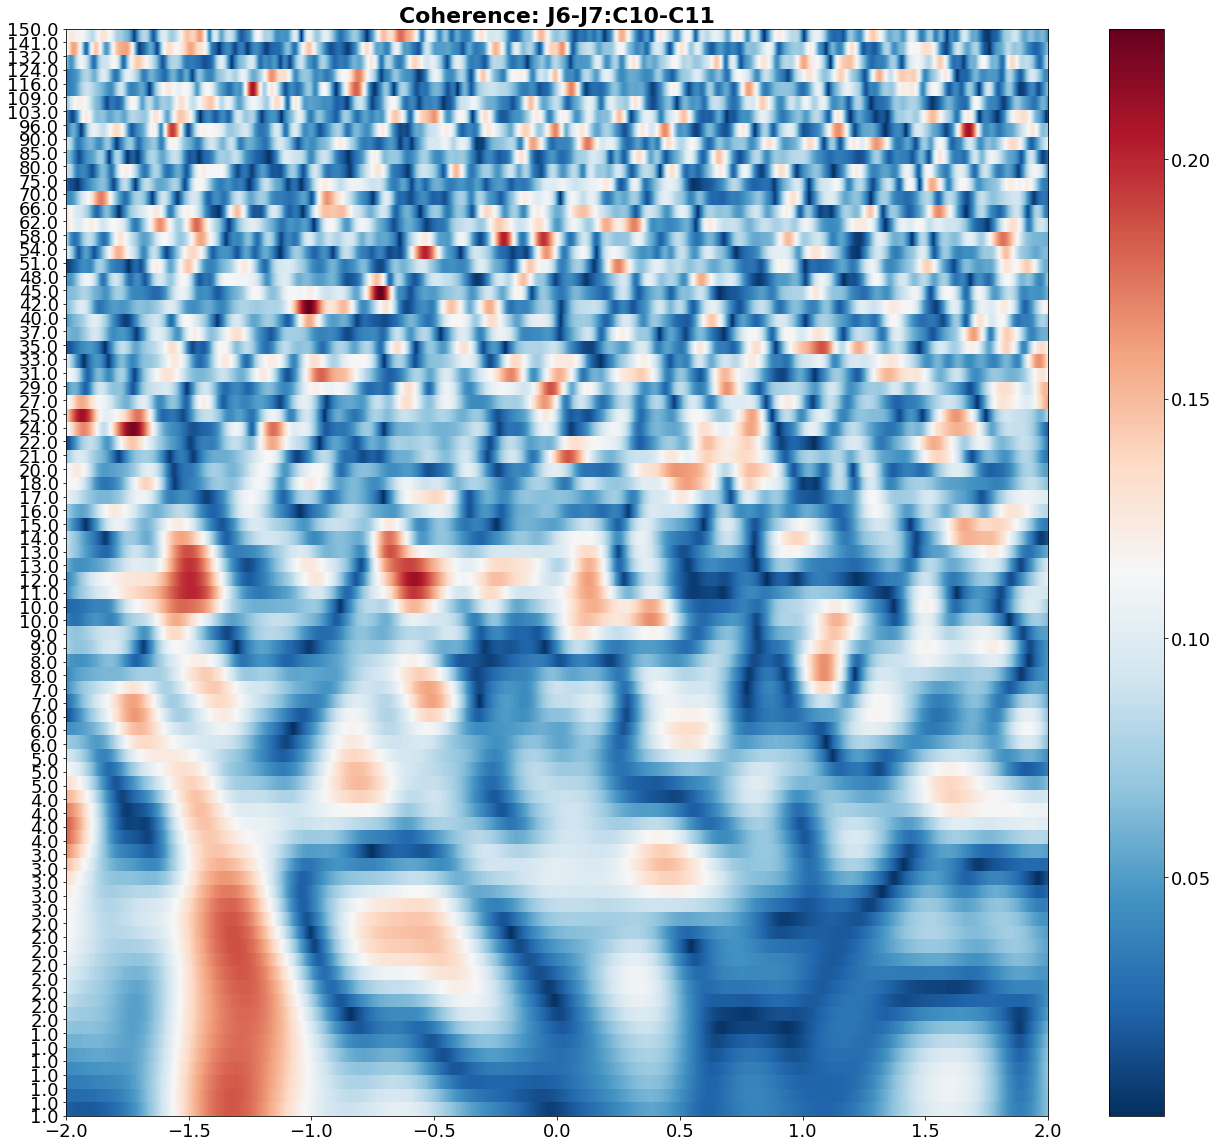

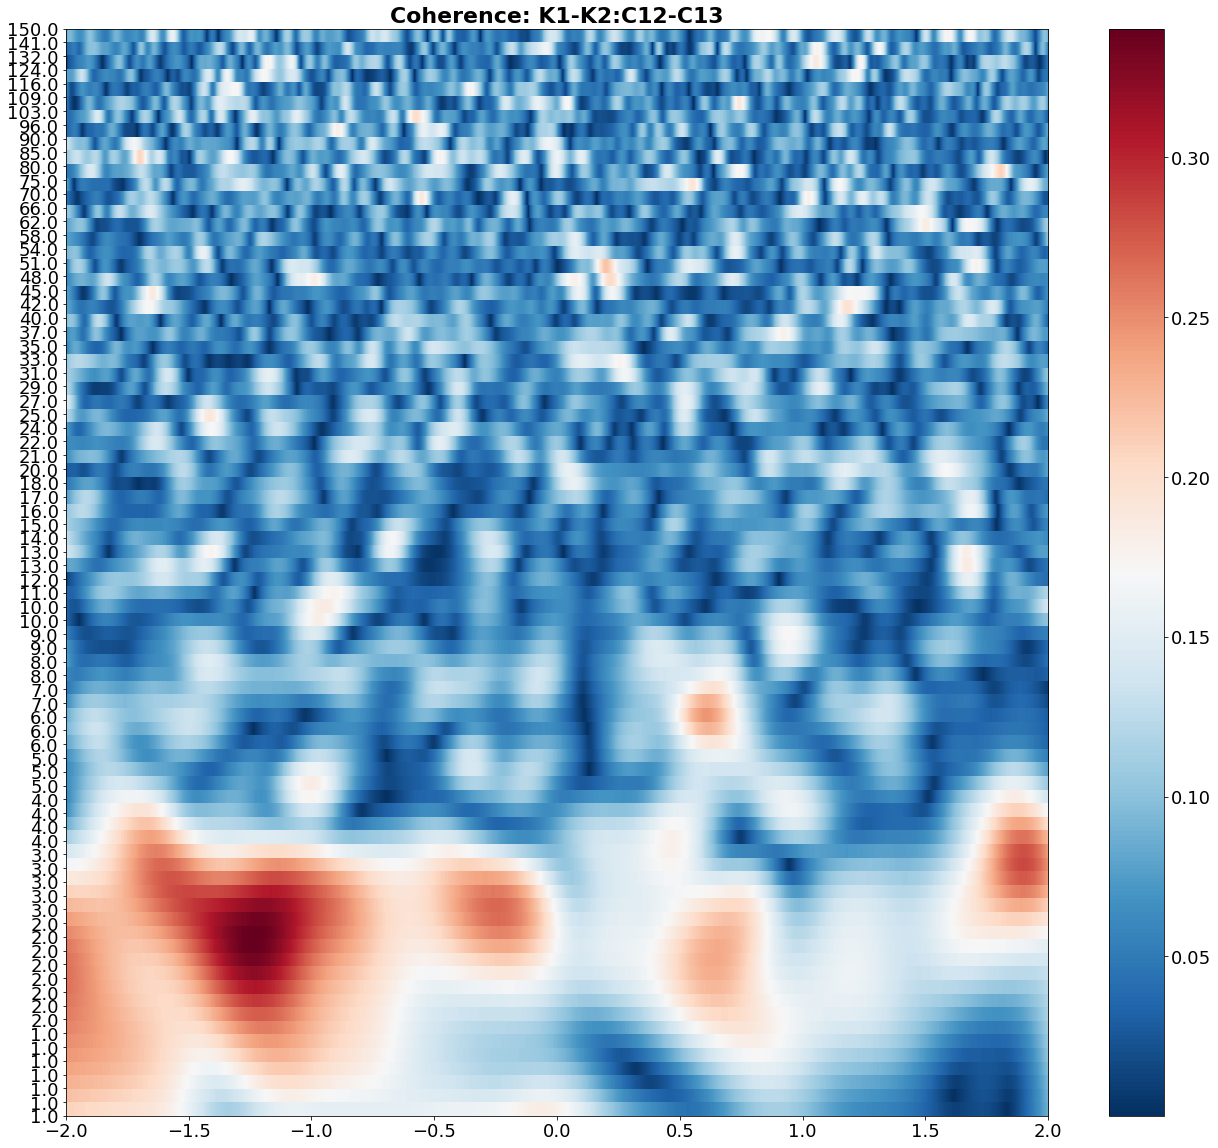

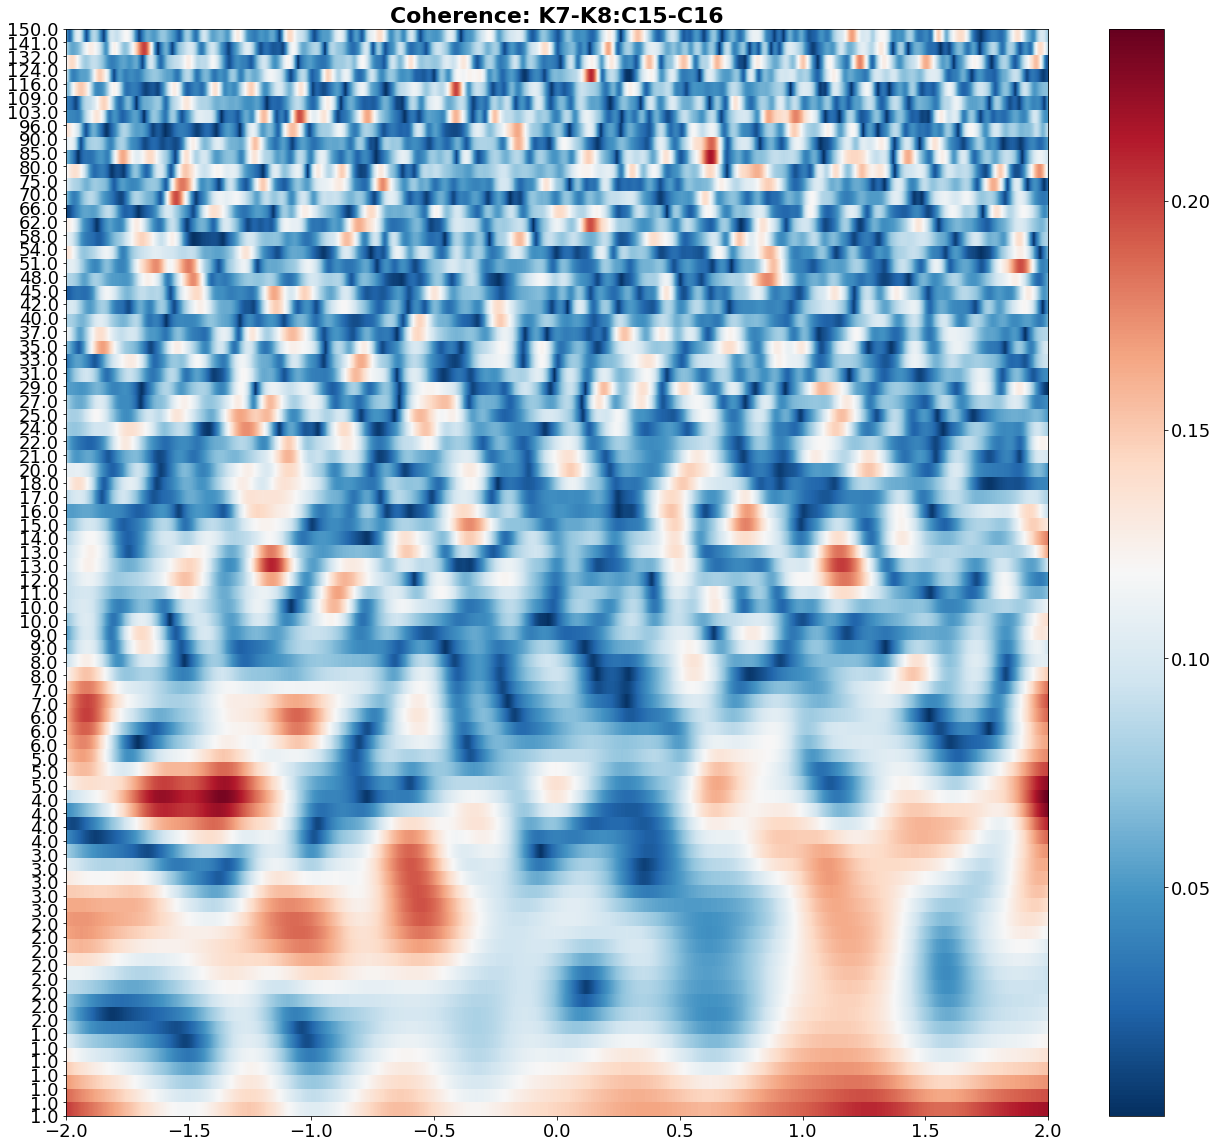

In [13]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[0].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherence: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherence: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherence: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


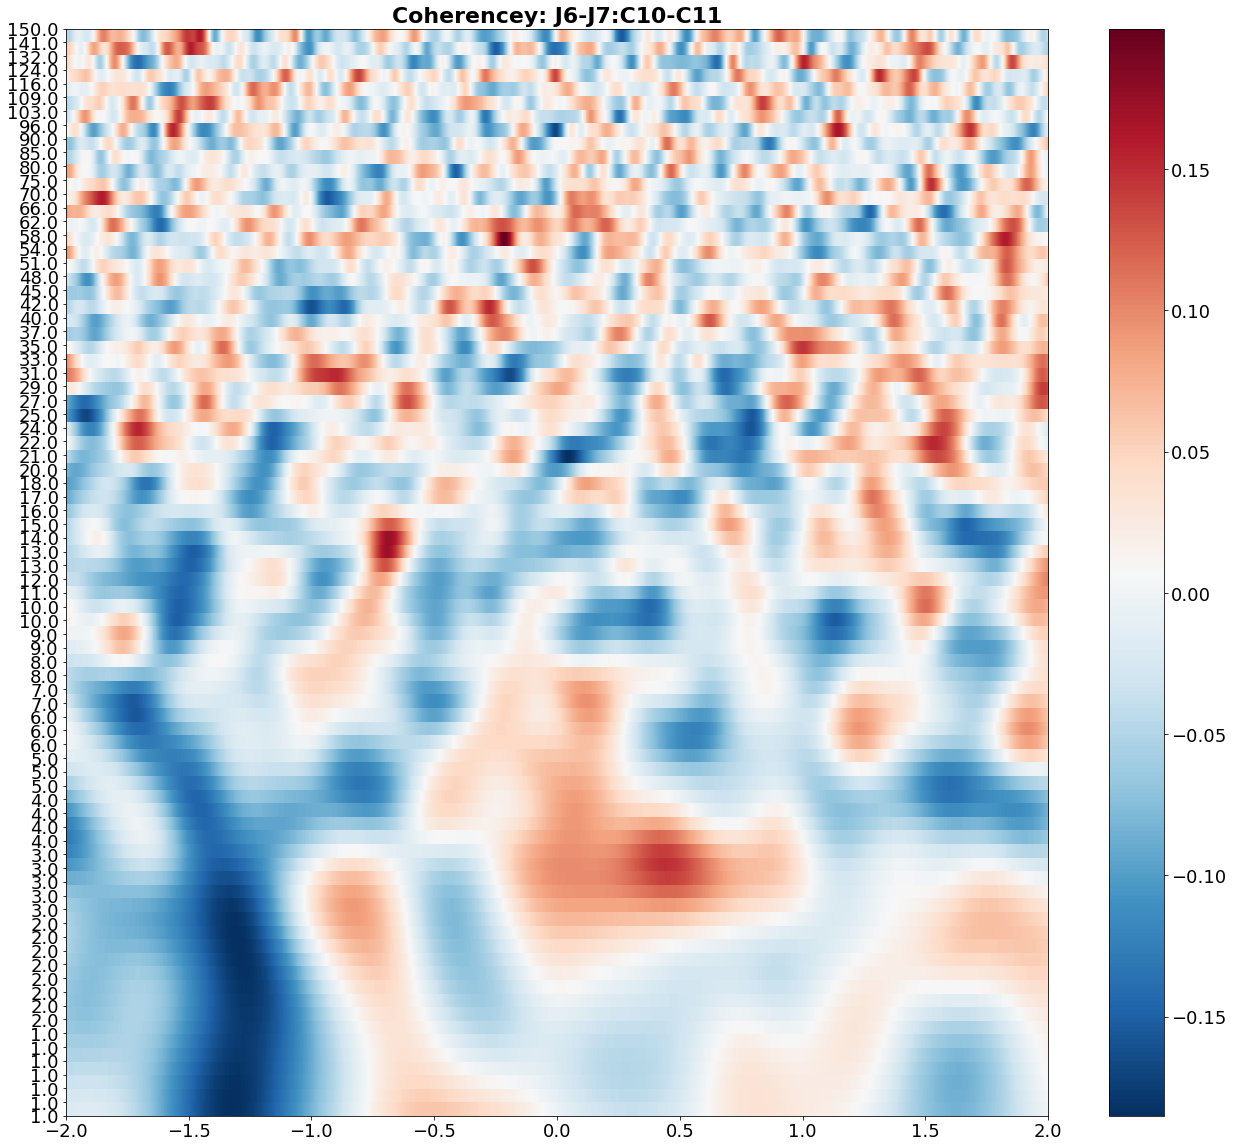

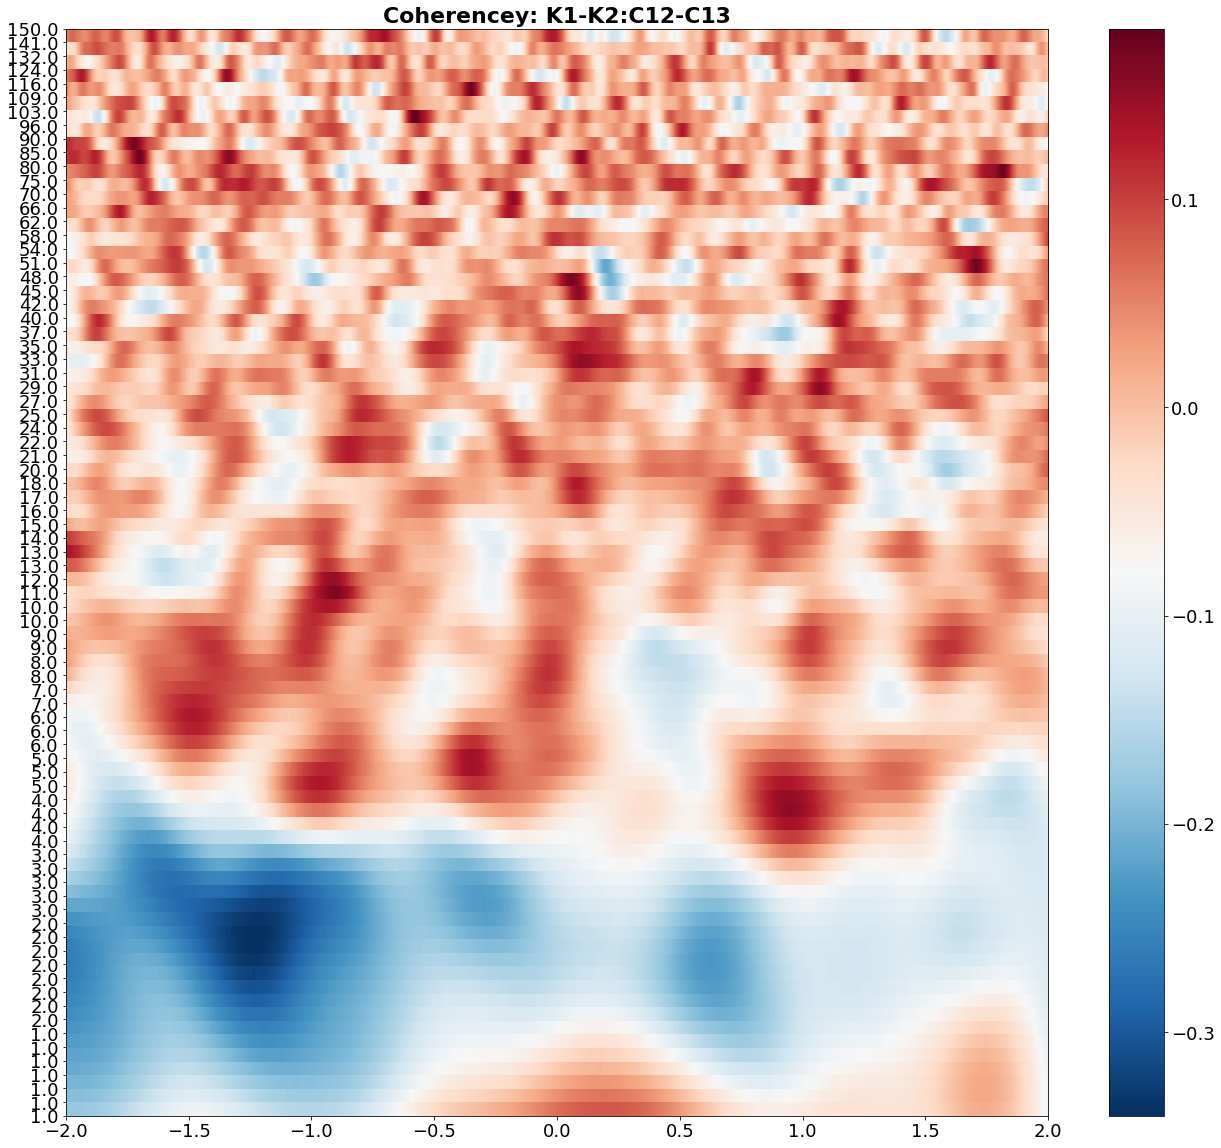

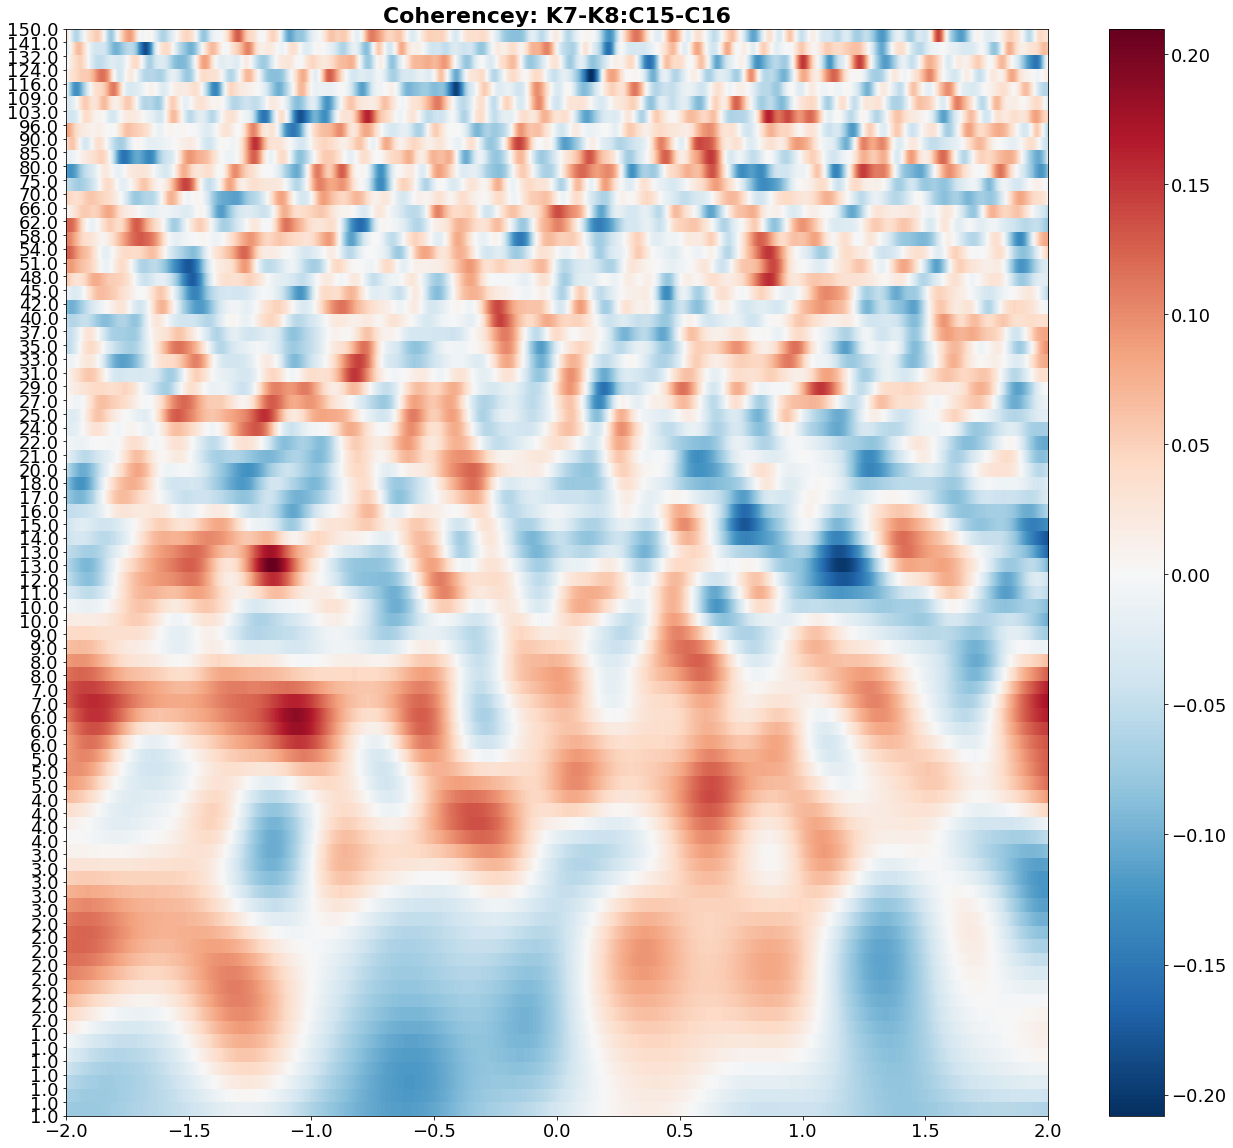

In [14]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = np.imag(roi_coherence[1].get_data('dense'))

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherencey: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherencey: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Coherencey: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


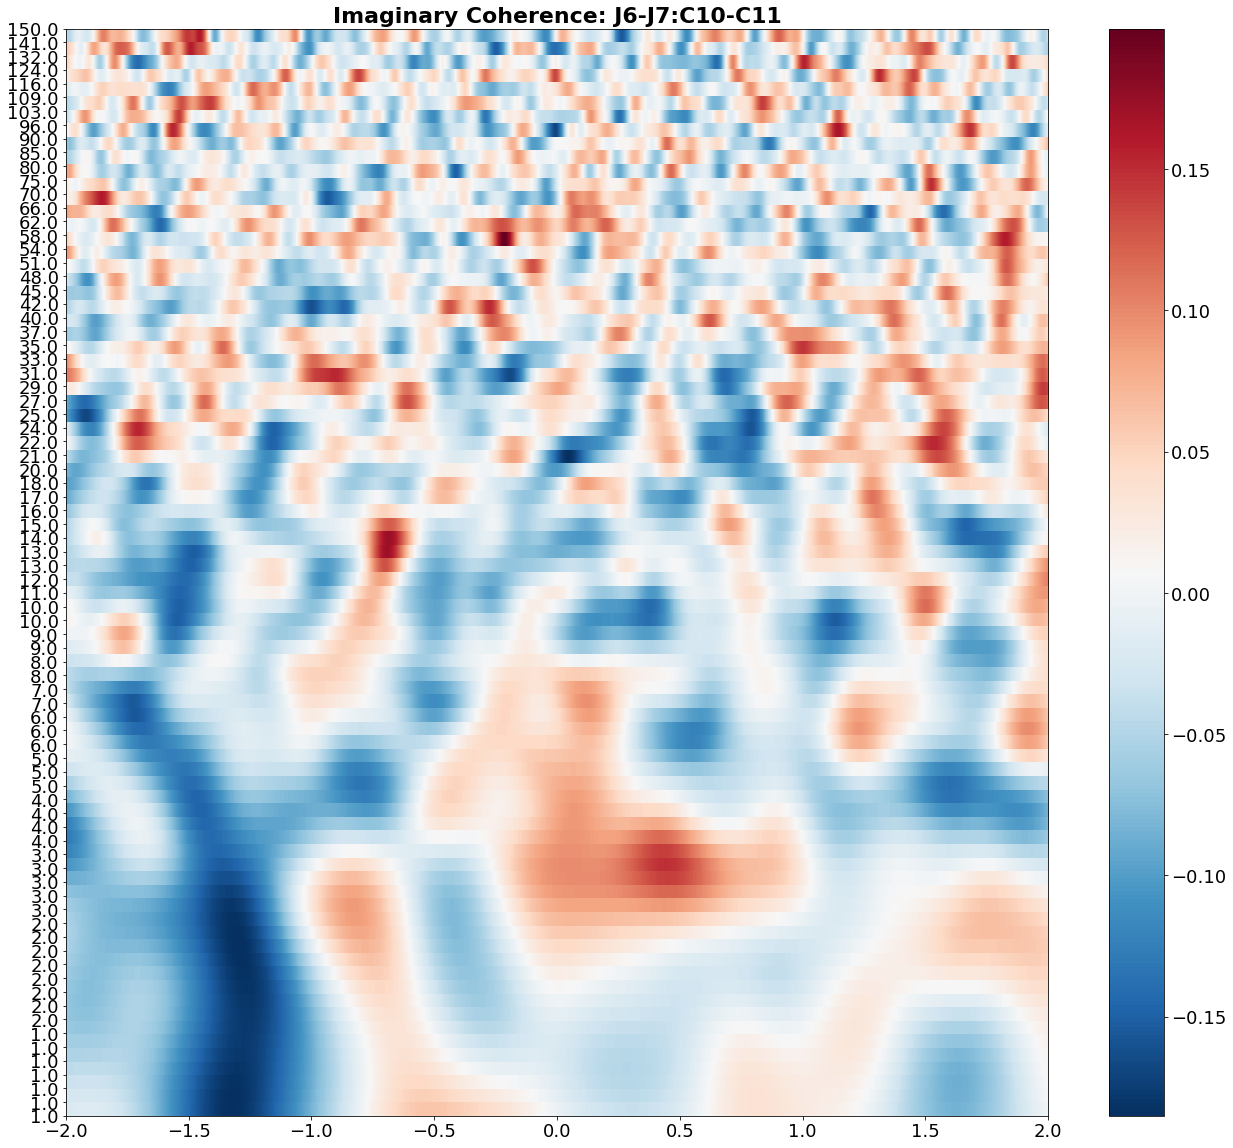

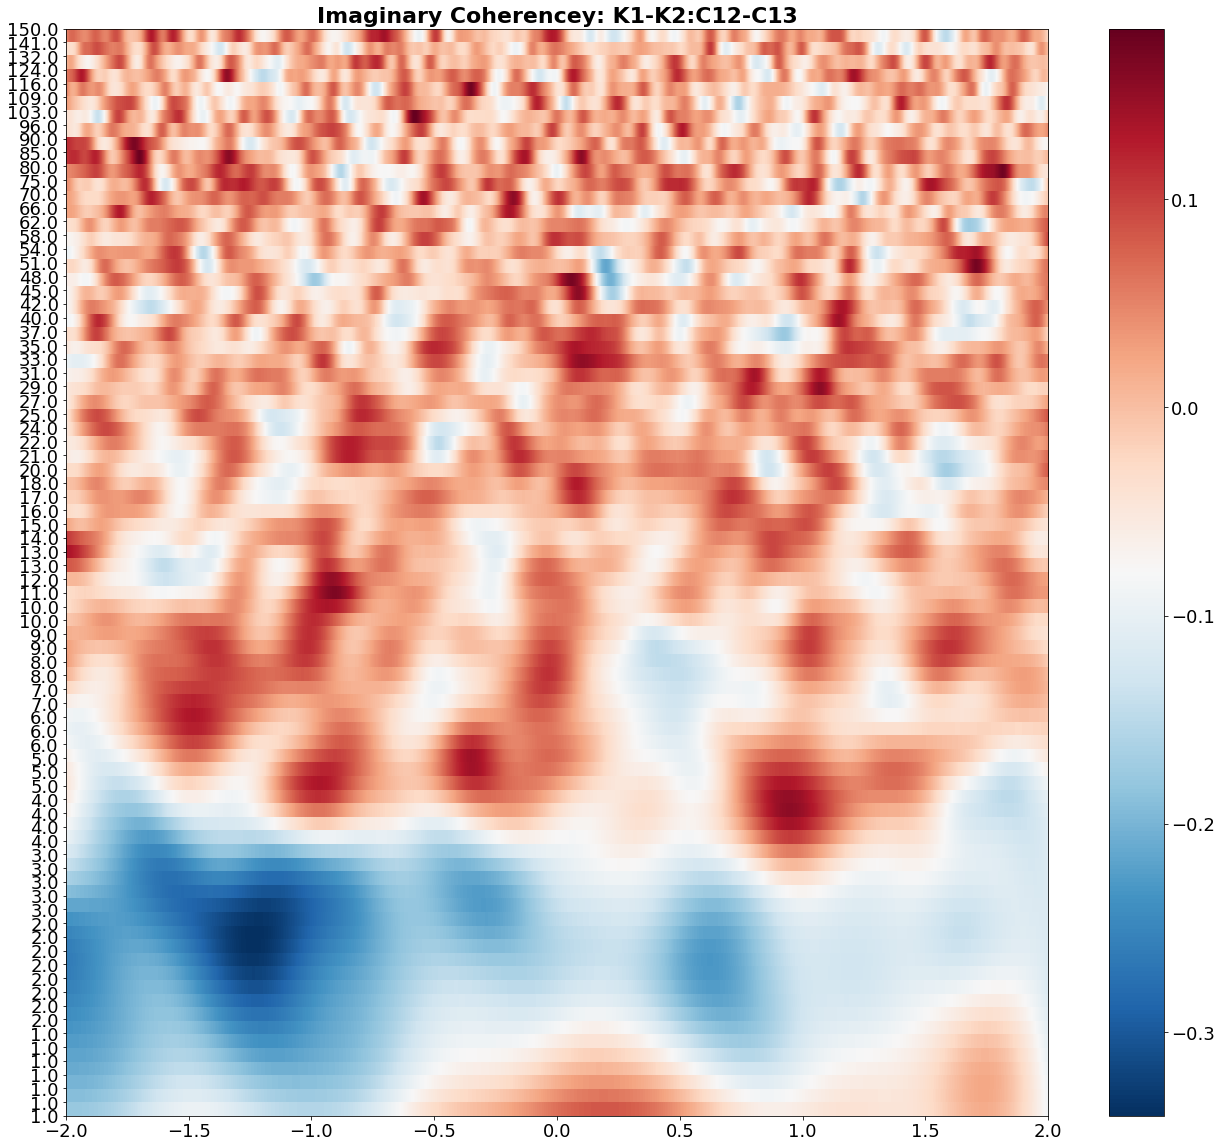

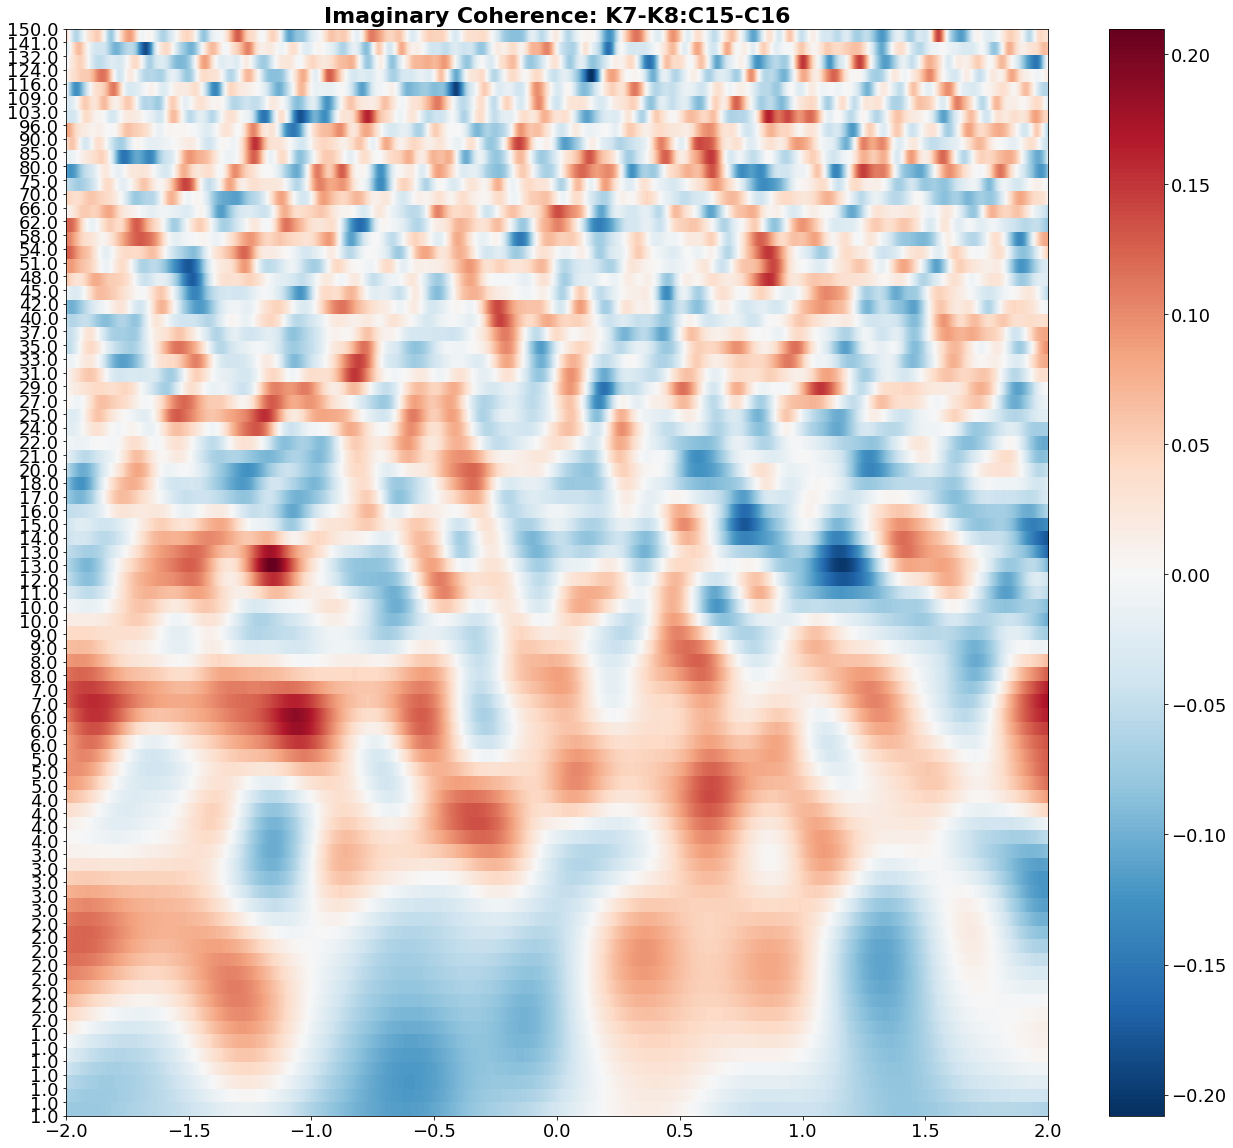

In [15]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[2].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Imaginary Coherence: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Imaginary Coherencey: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Imaginary Coherence: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


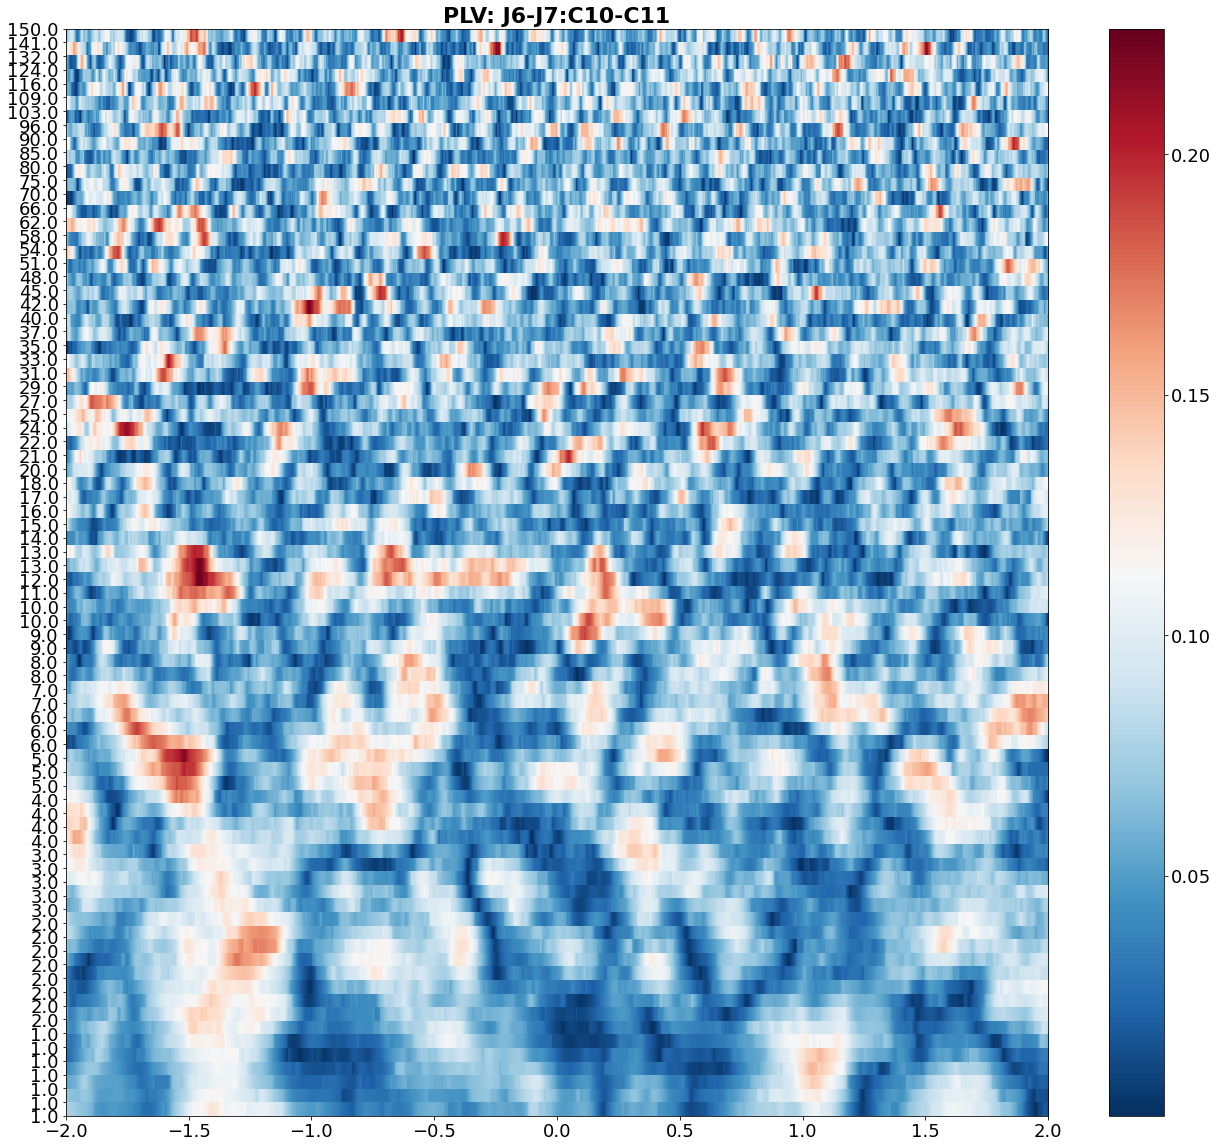

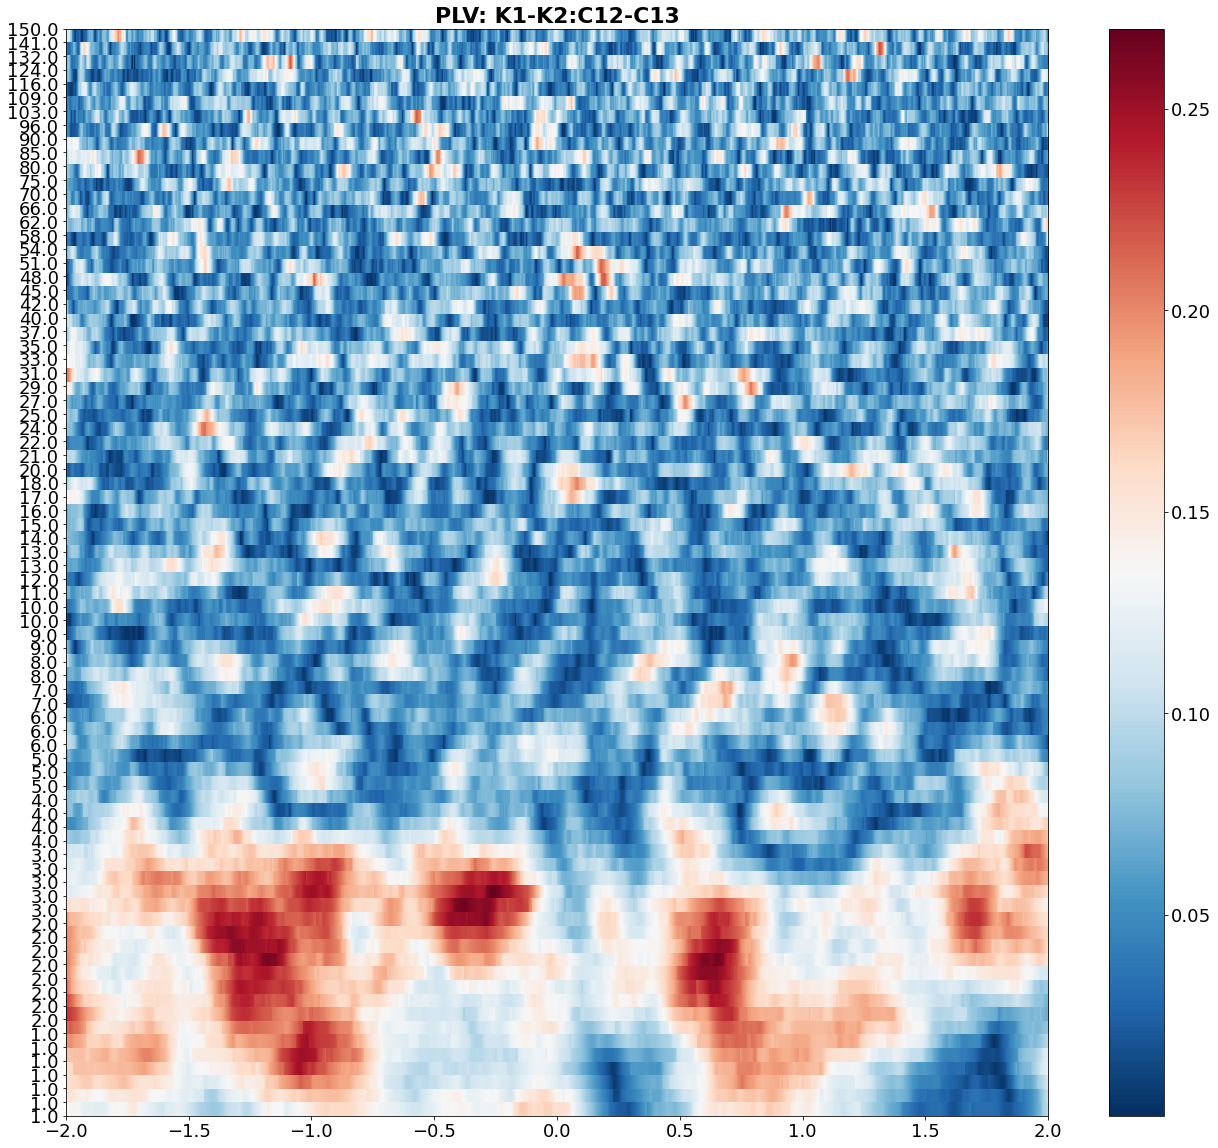

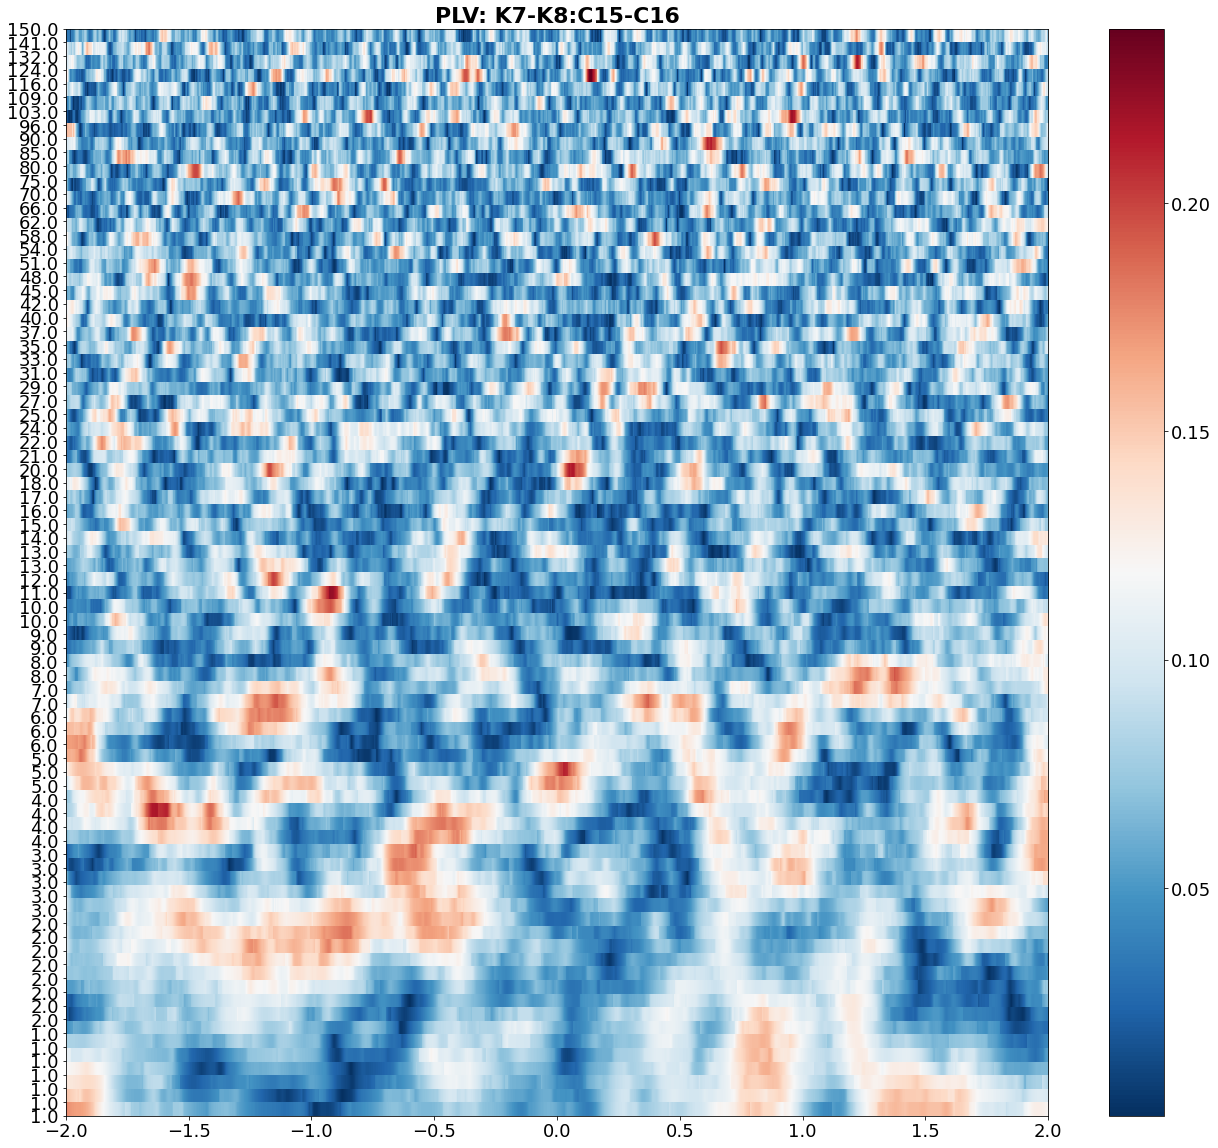

In [16]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[3].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("PLV: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("PLV: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("PLV: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


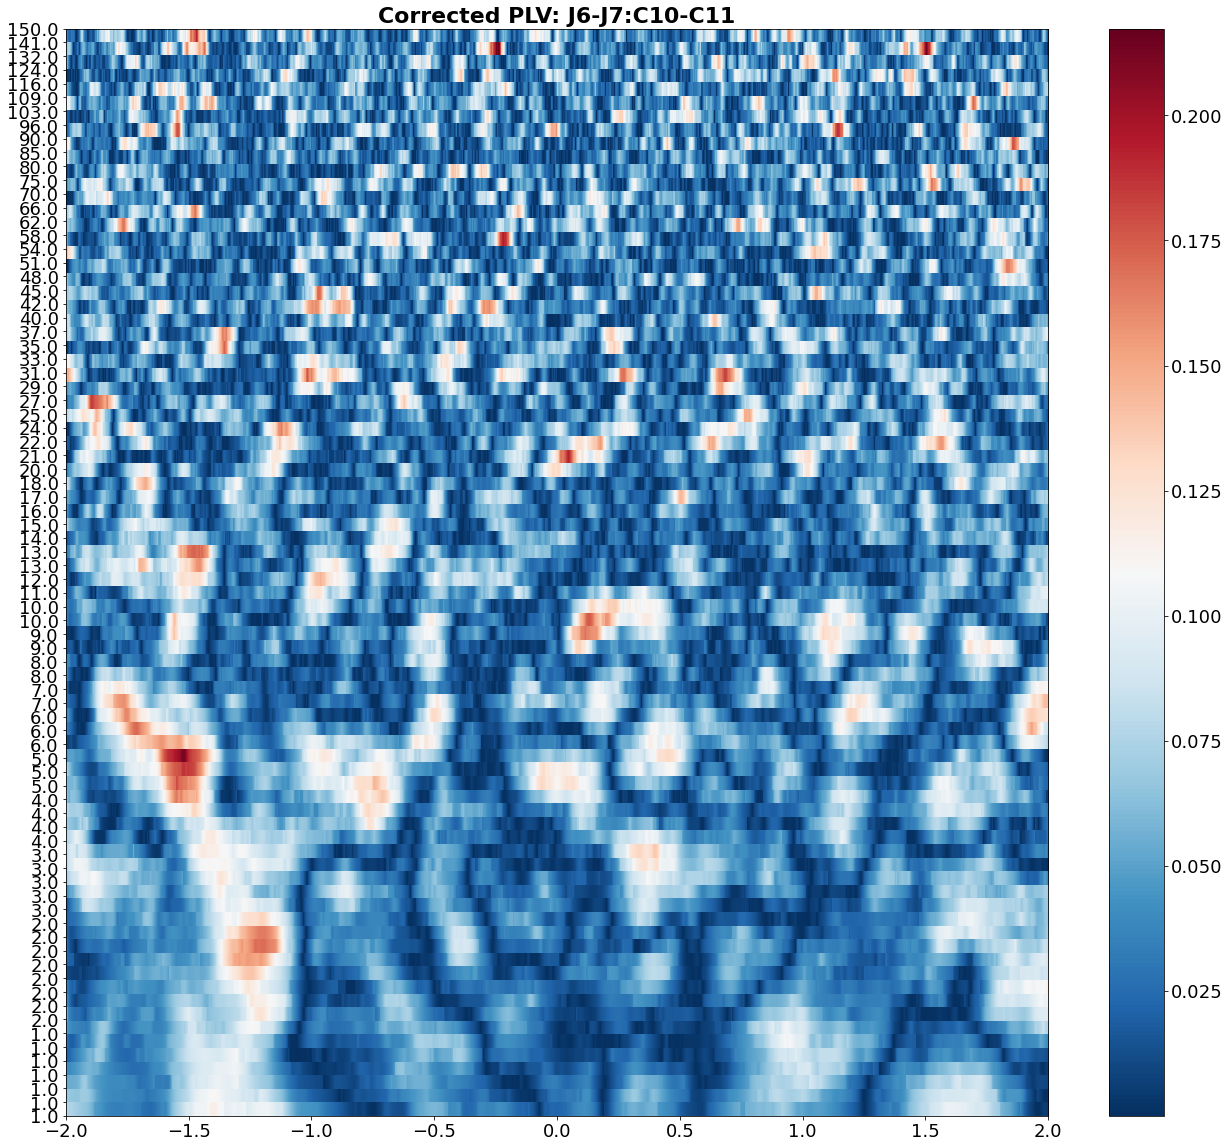

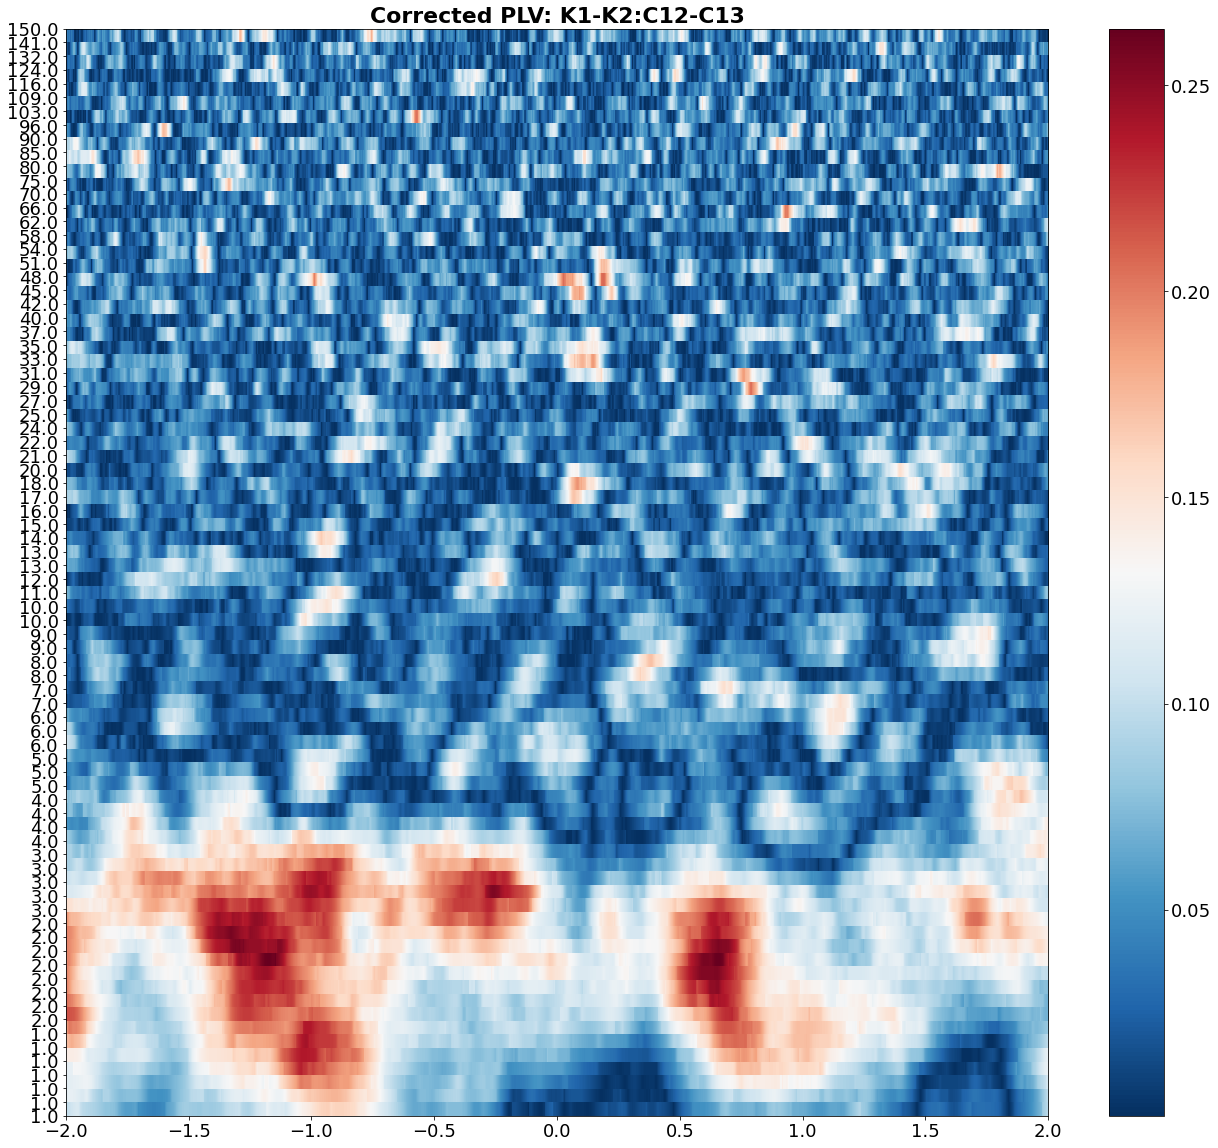

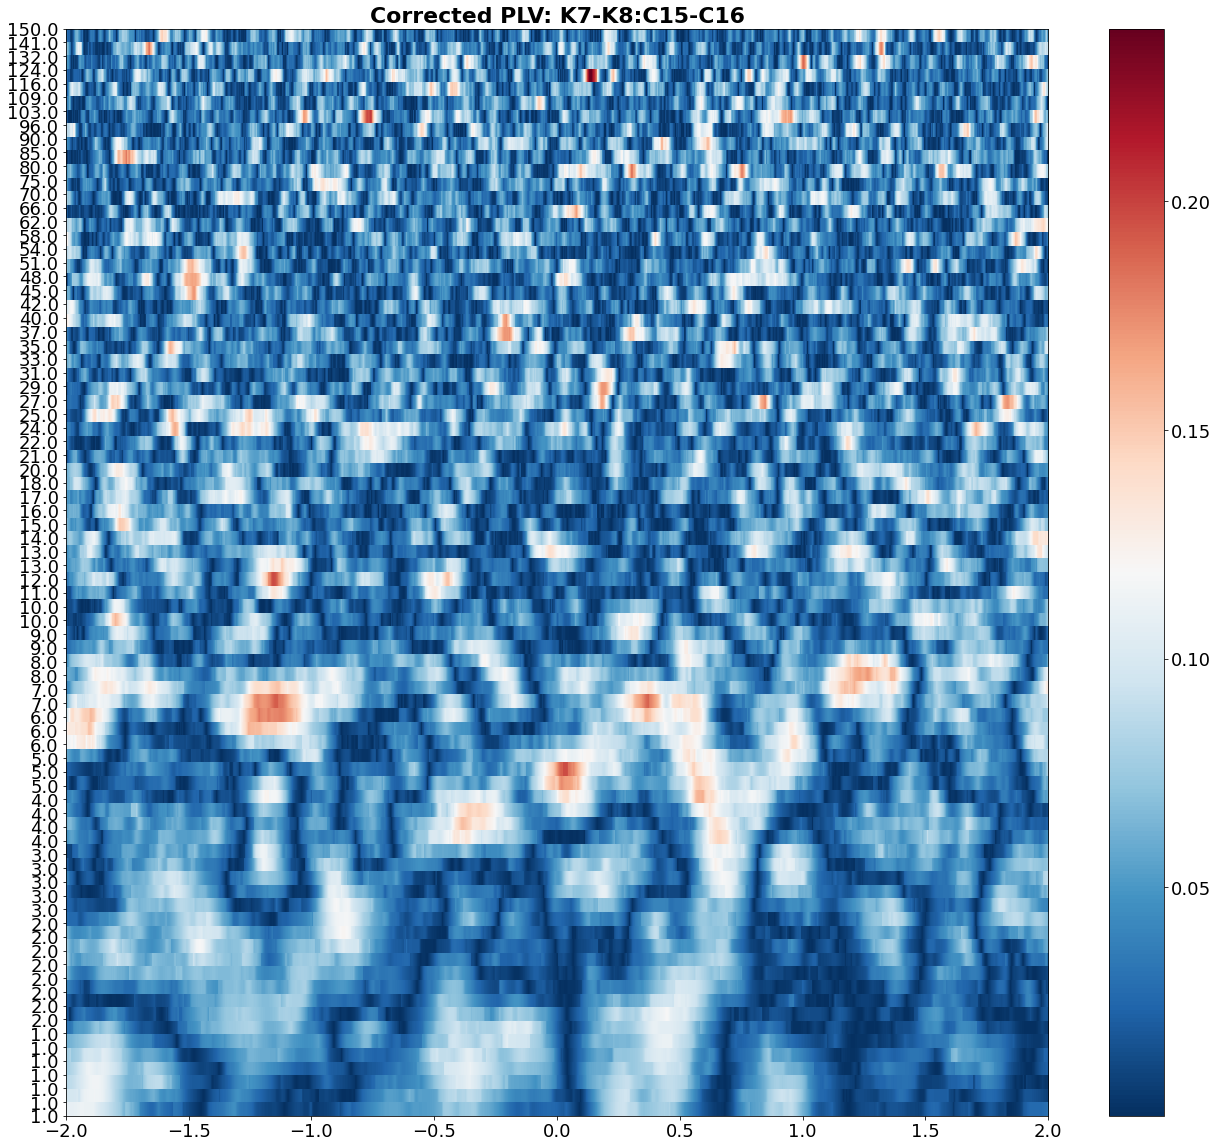

In [17]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[4].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Corrected PLV: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Corrected PLV: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Corrected PLV: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


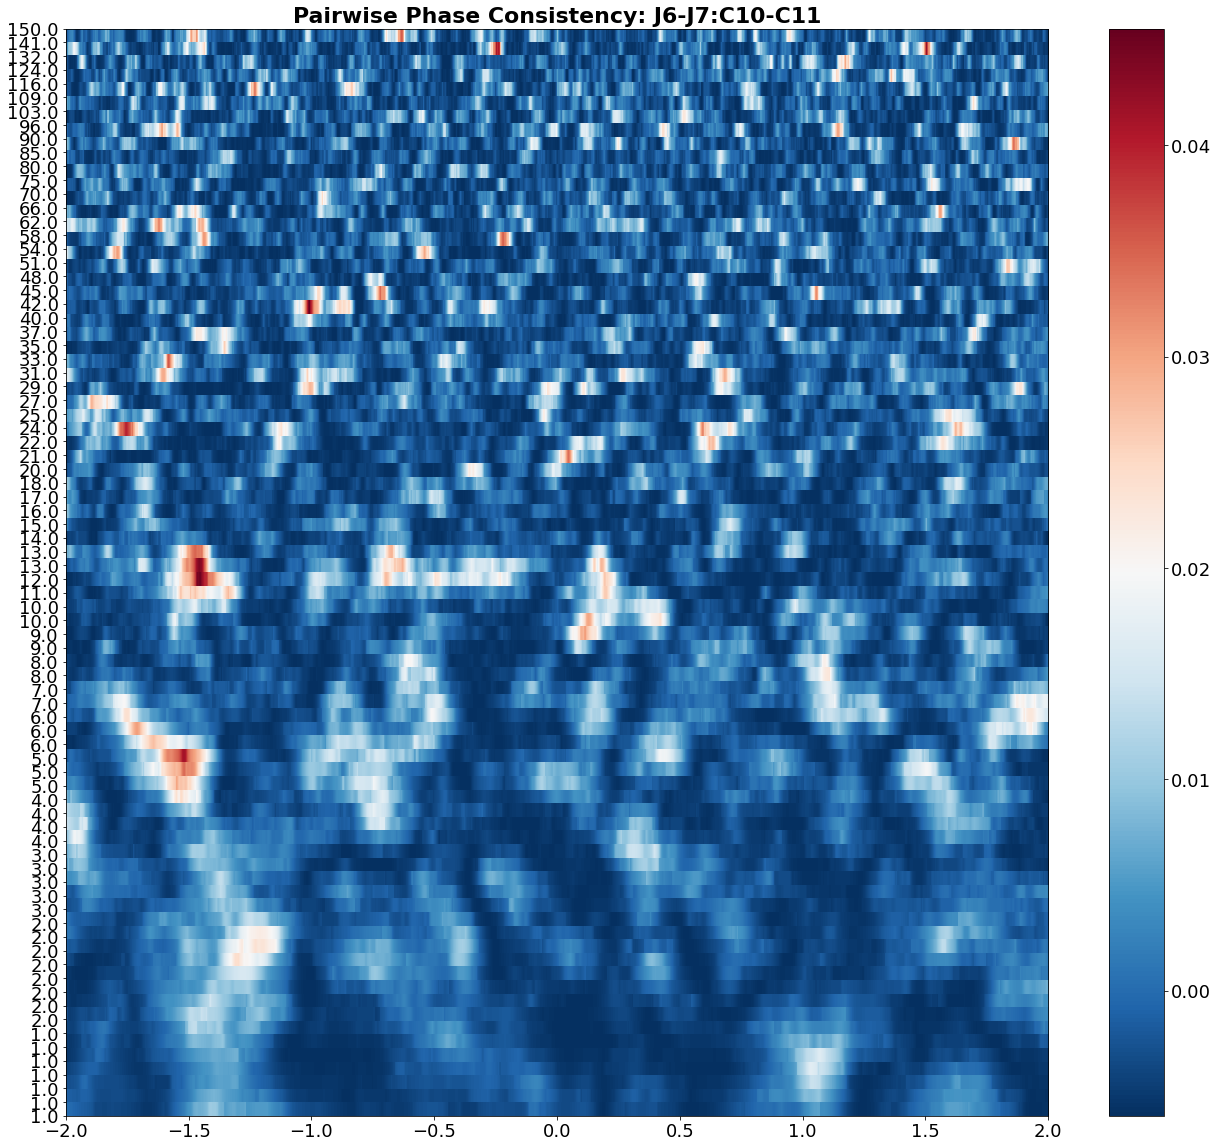

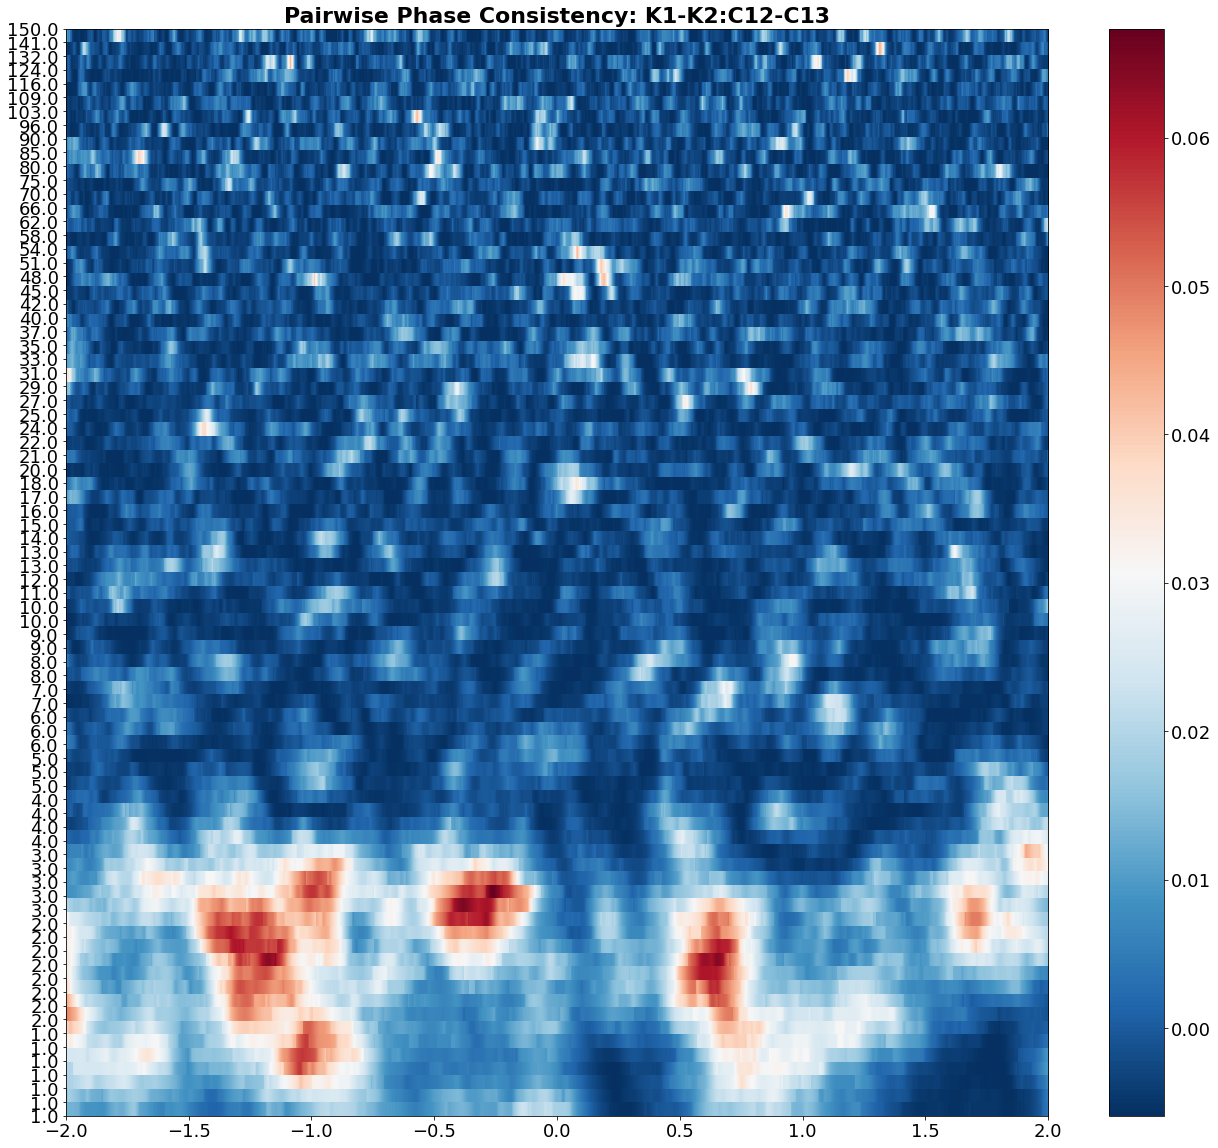

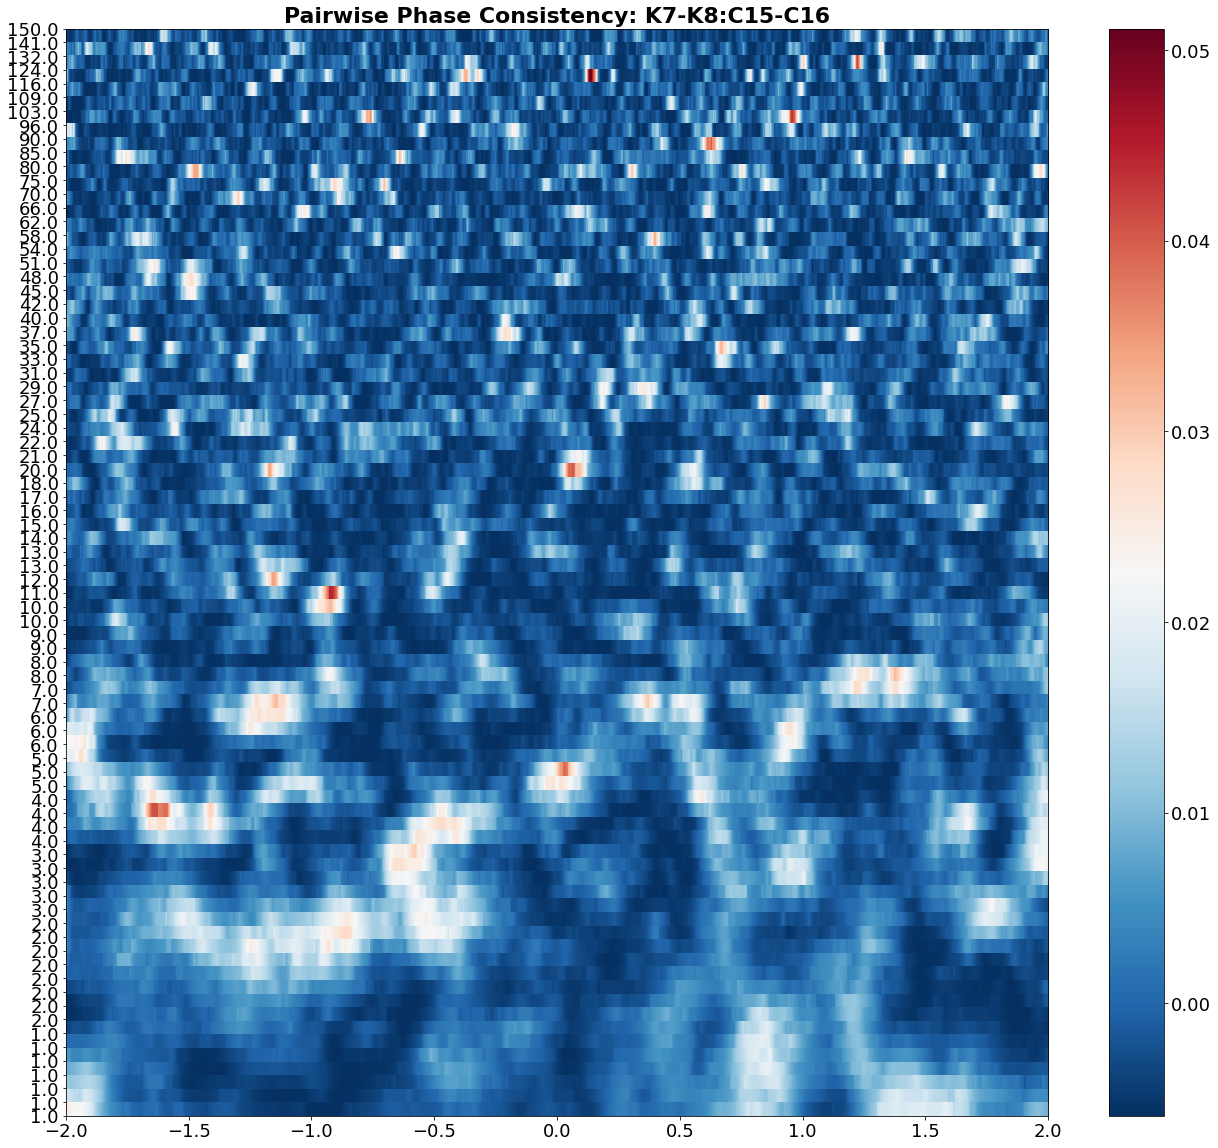

In [18]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[5].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Pairwise Phase Consistency: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Pairwise Phase Consistency: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Pairwise Phase Consistency: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


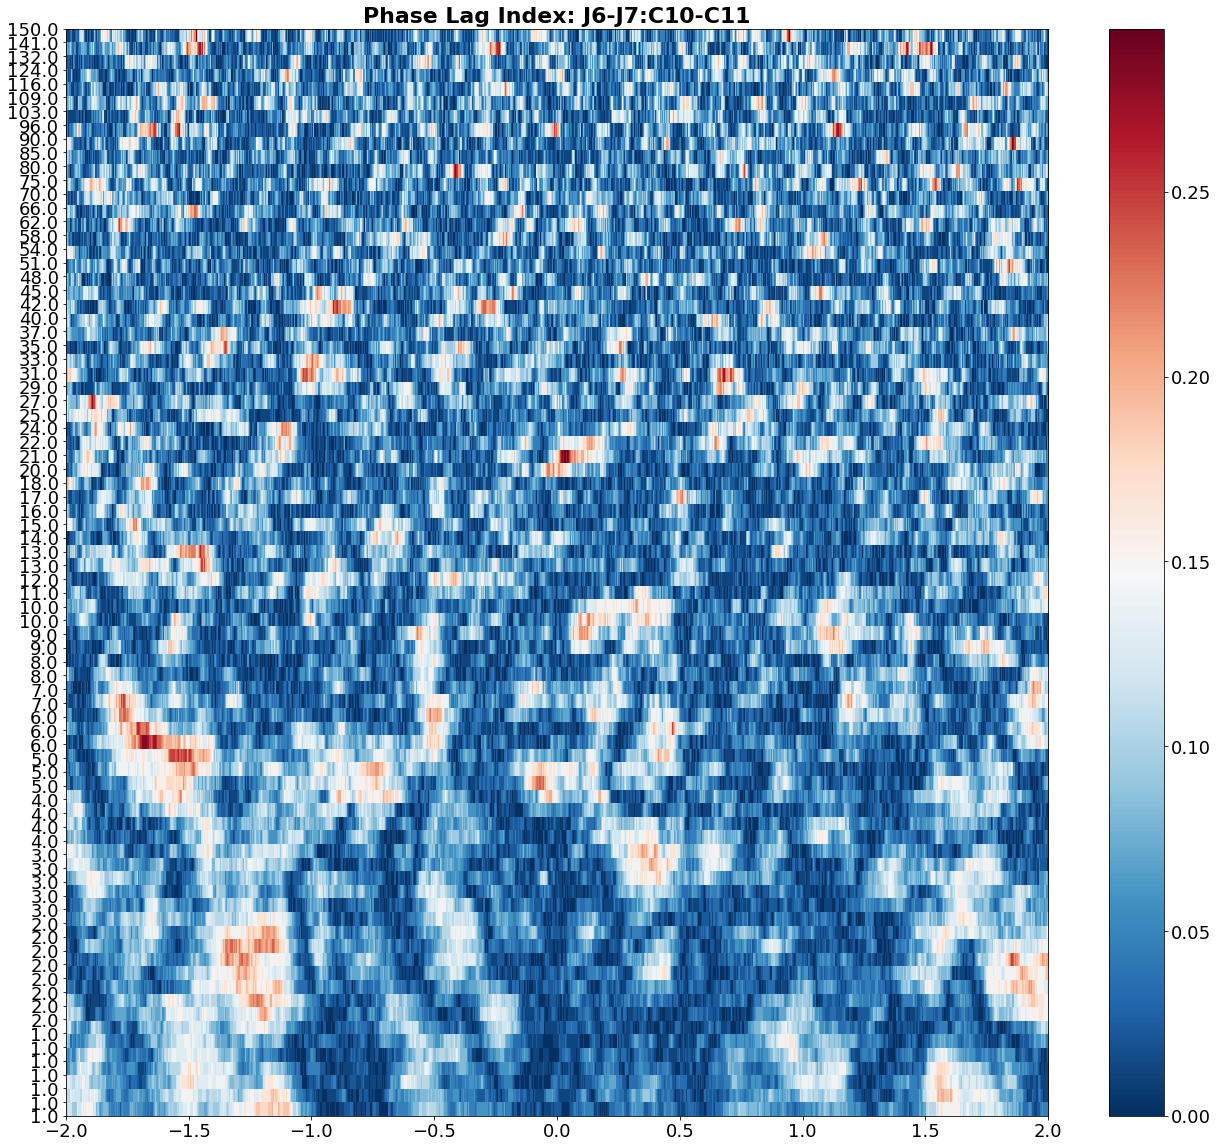

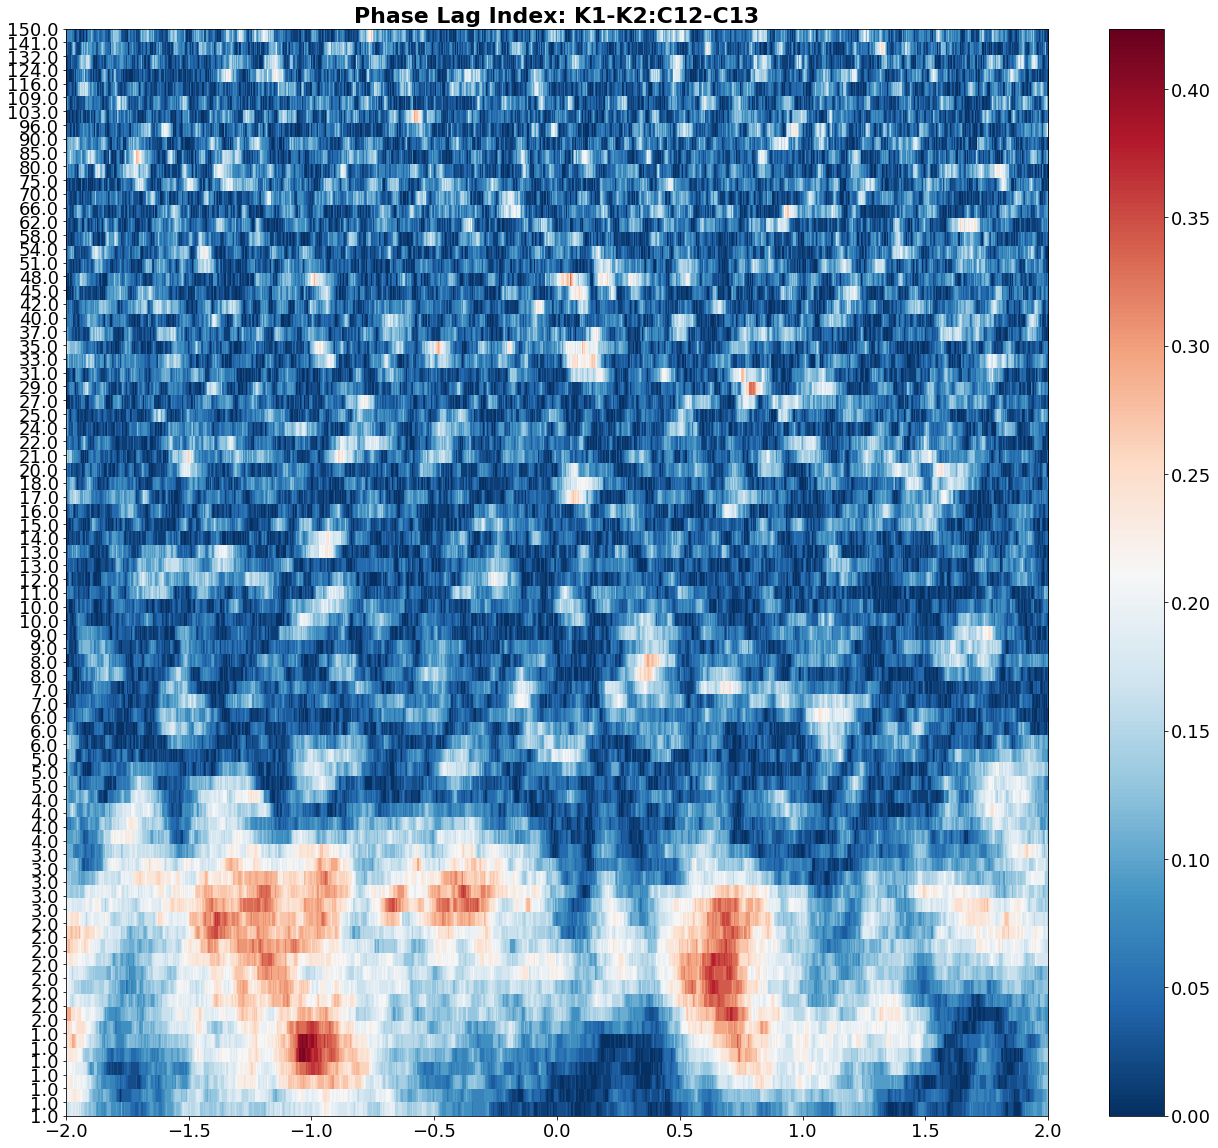

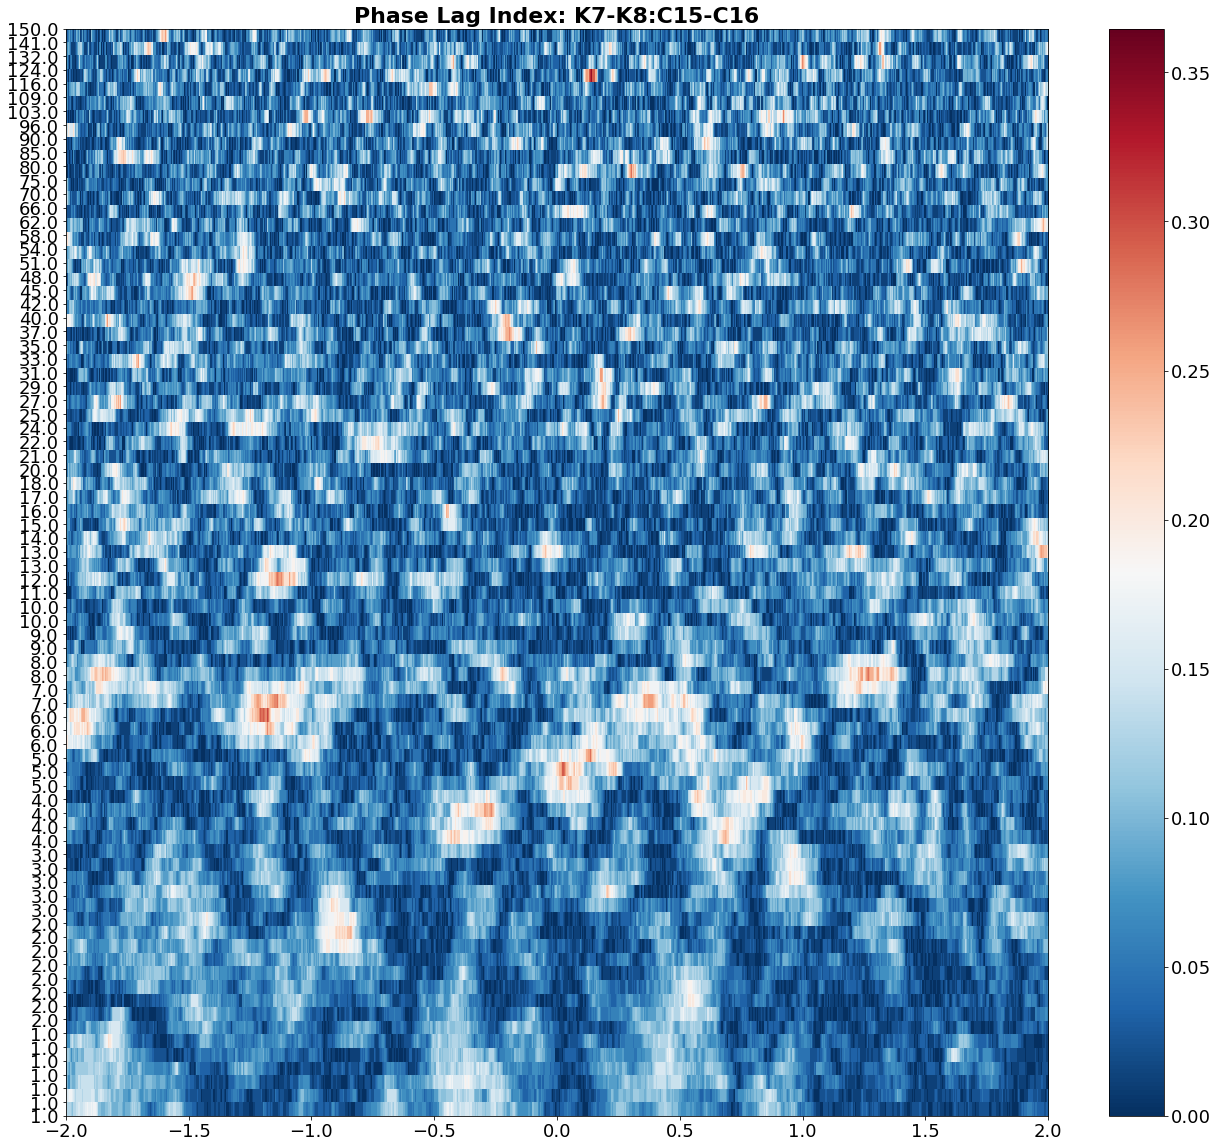

In [19]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[6].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Phase Lag Index: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Phase Lag Index: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Phase Lag Index: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


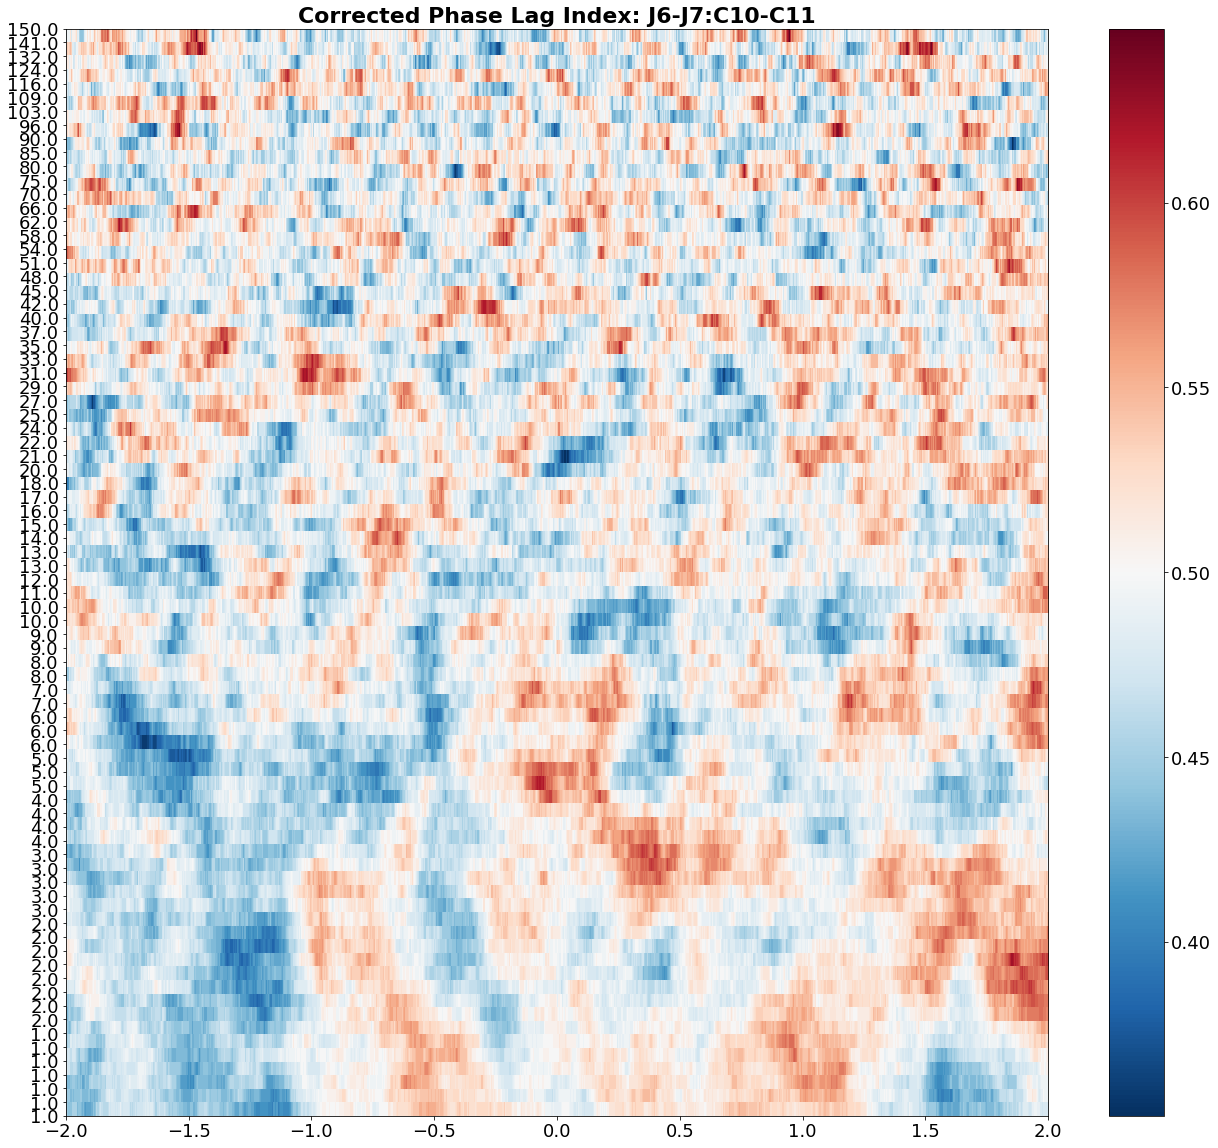

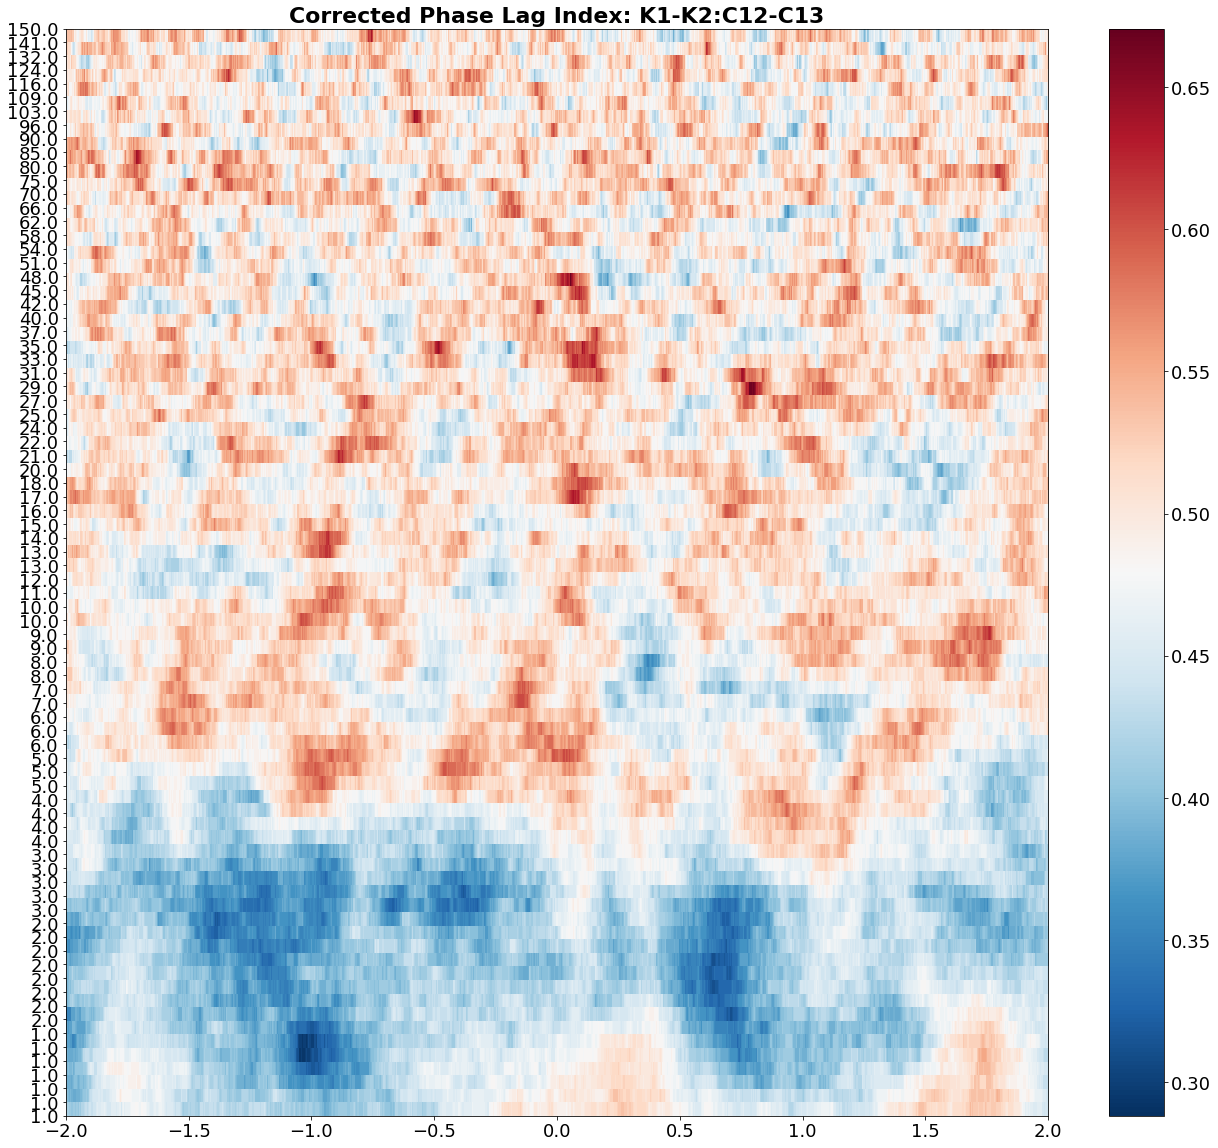

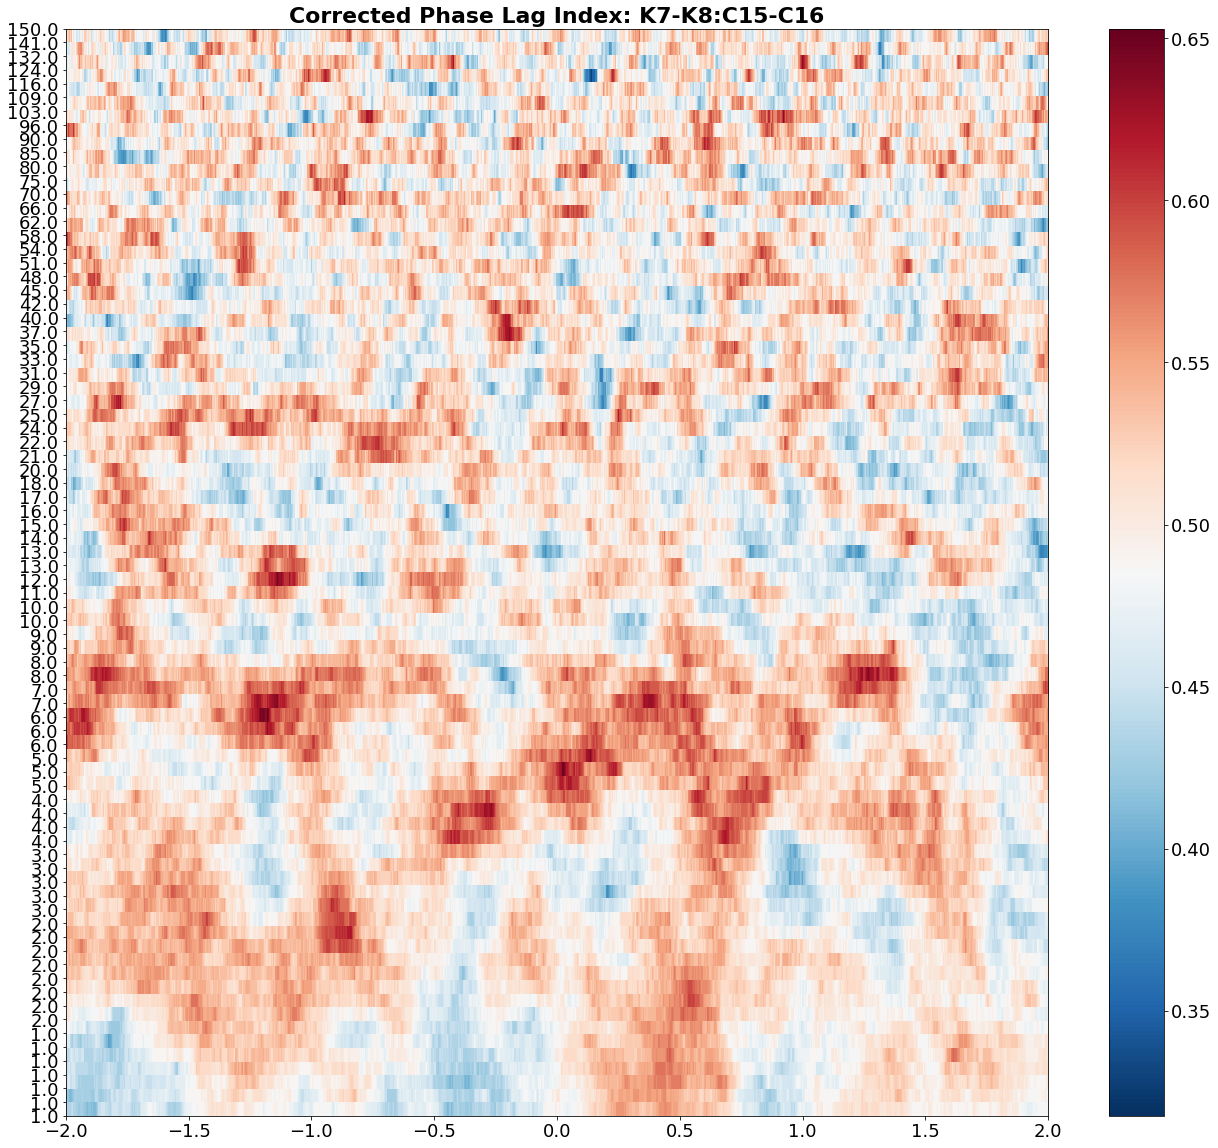

In [20]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[7].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Corrected Phase Lag Index: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Corrected Phase Lag Index: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Corrected Phase Lag Index: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


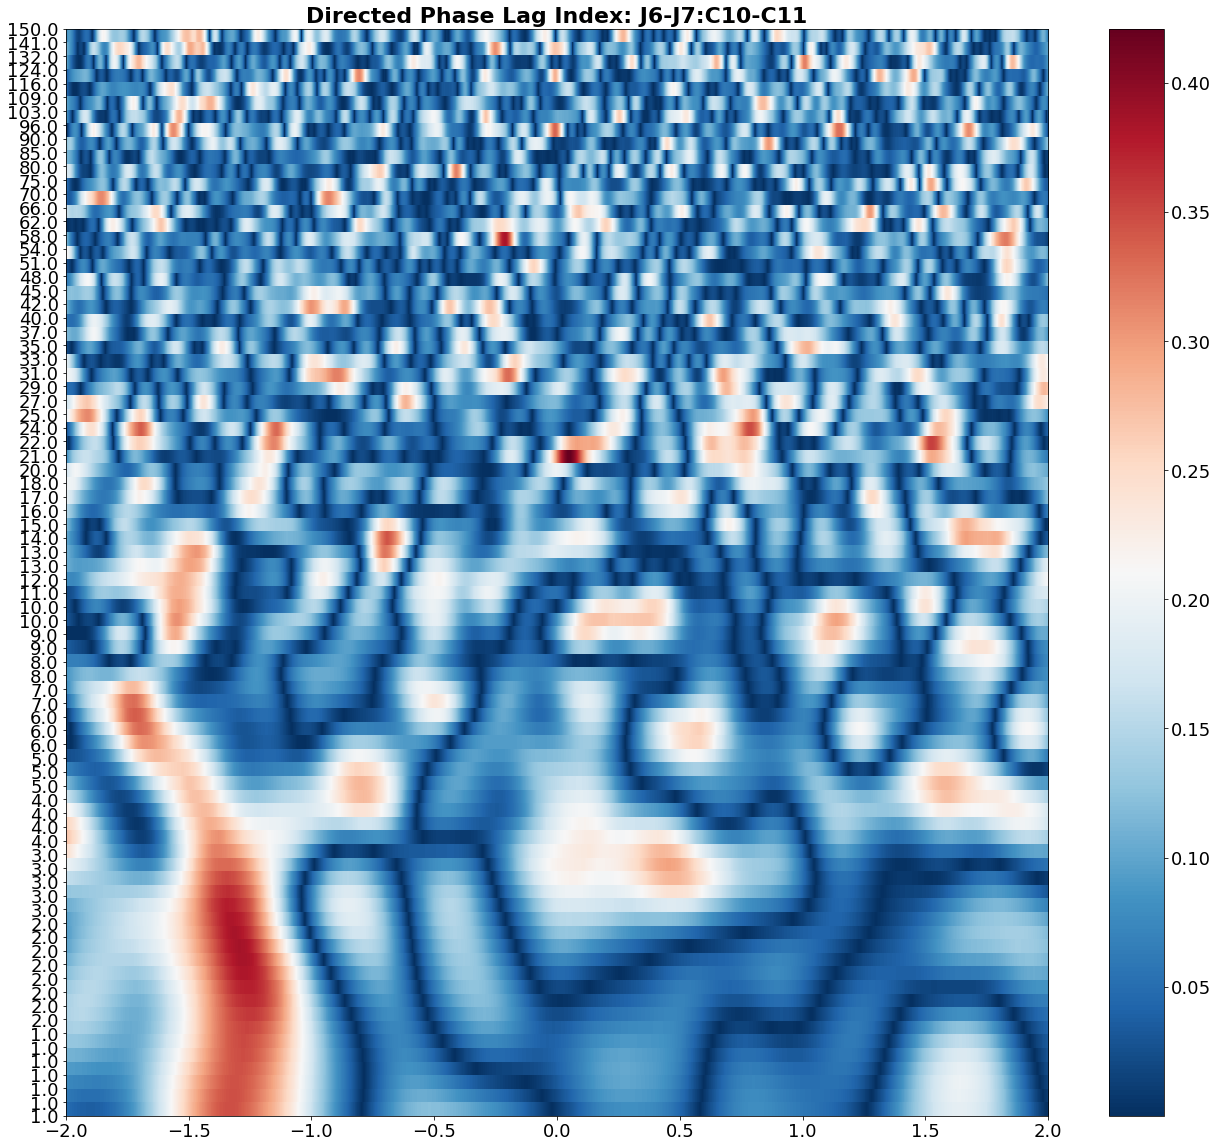

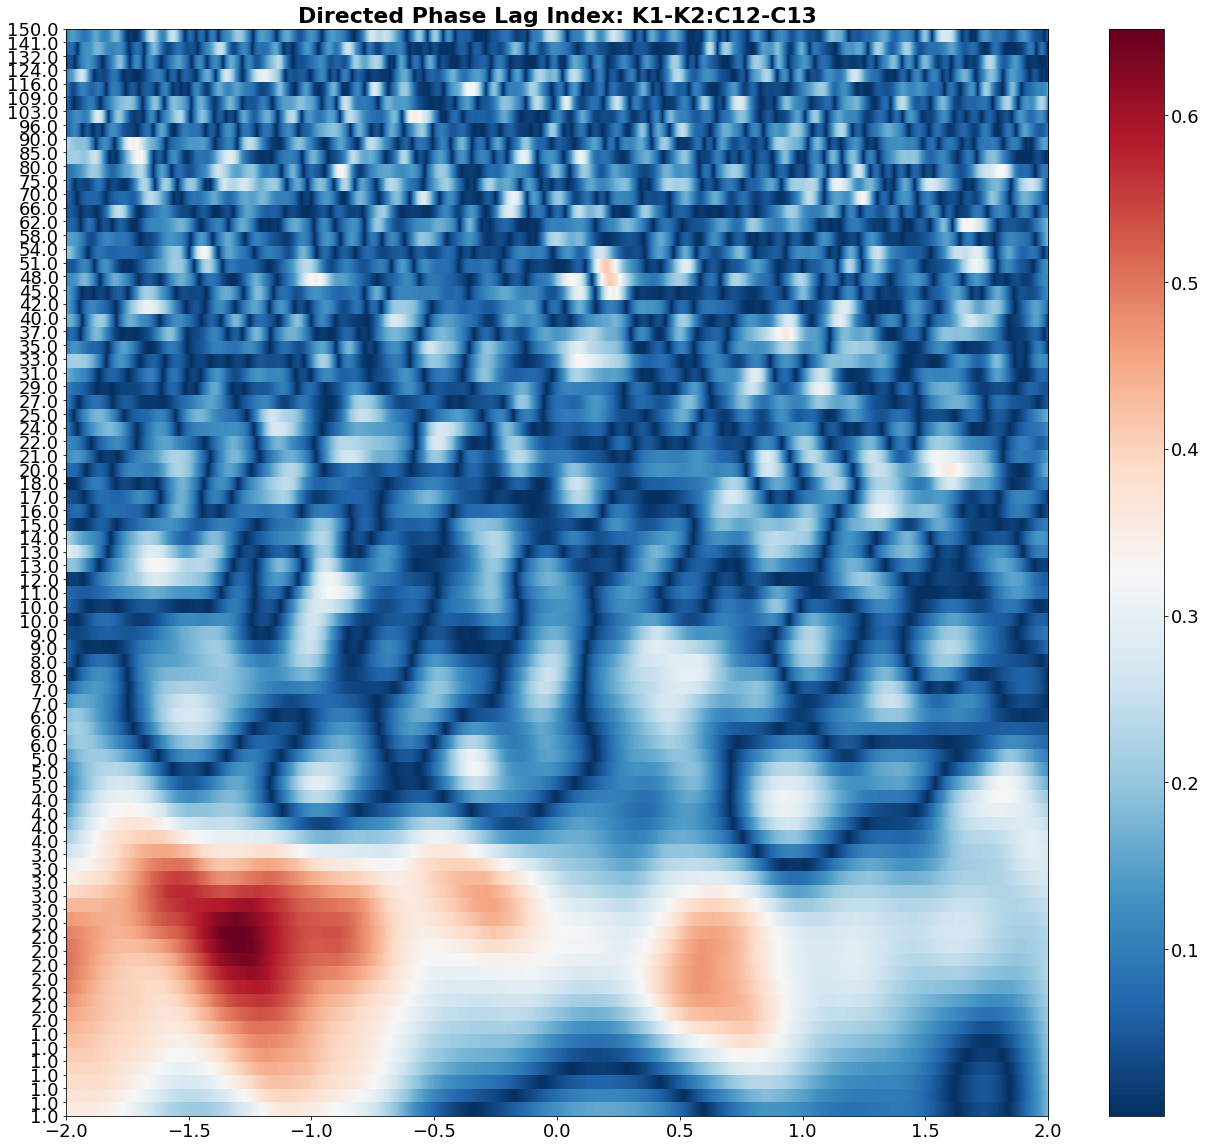

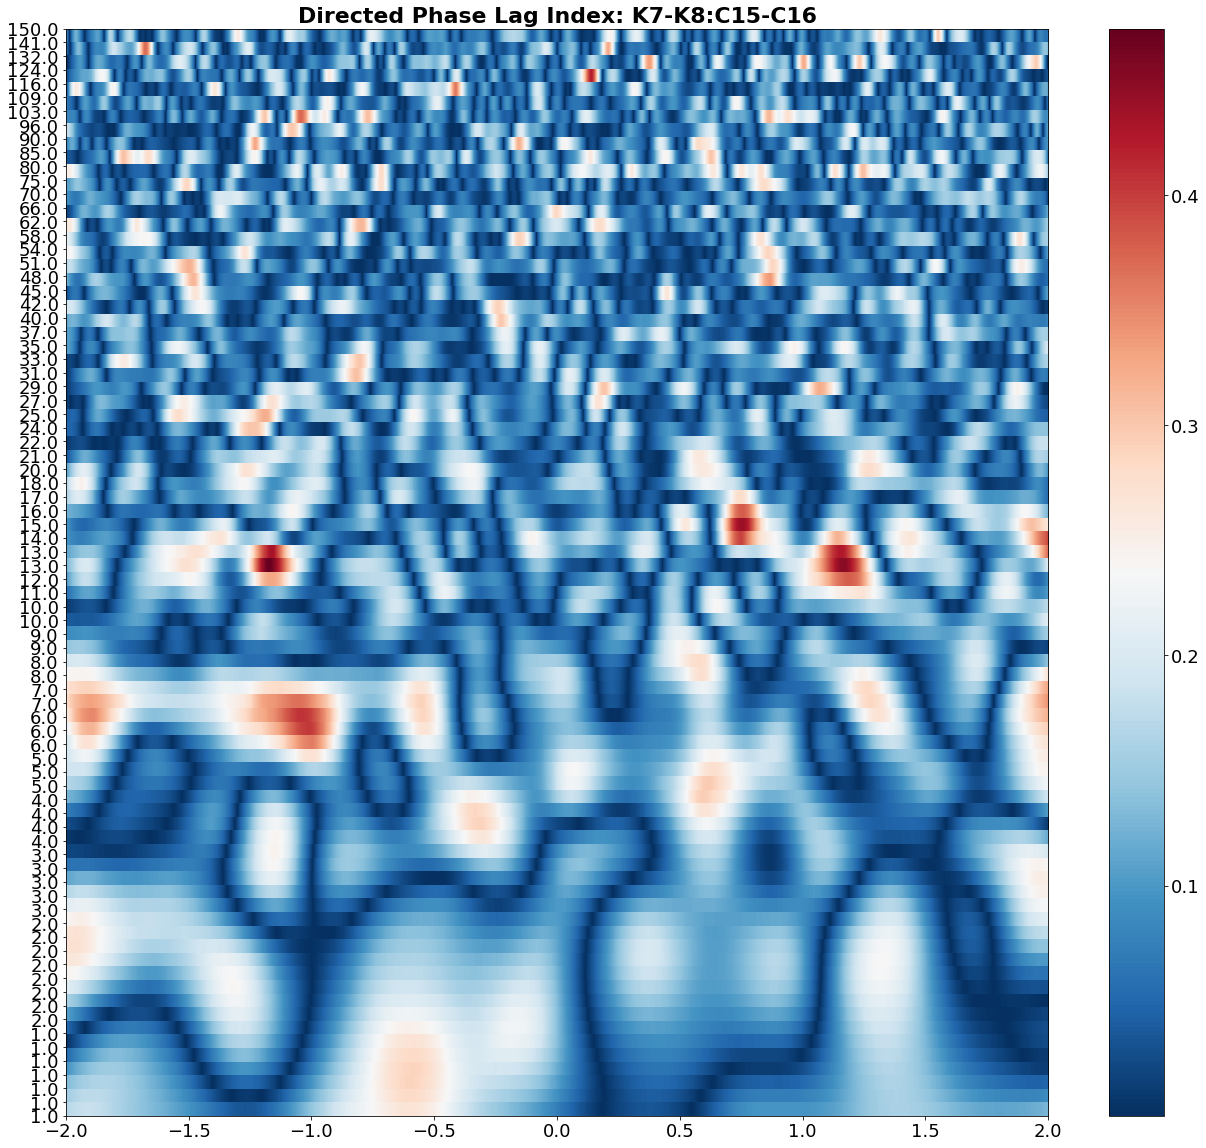

In [21]:
plt.rcParams['figure.figsize'] = [22, 20]
plt.rcParams.update({'font.size': 18})

tmp = roi_coherence[8].get_data('dense')

fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[3, 0, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Directed Phase Lag Index: J6-J7:C10-C11", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[4, 1, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Directed Phase Lag Index: K1-K2:C12-C13", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()


fig, ax = plt.subplots(figsize = (22, 20))
i = ax.imshow(tmp[5, 2, :, 3000:7000], cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]])
ax.set_yticks(np.linspace(np.min(freqs),np.max(freqs),len(freqs)))
ax.set_yticklabels(np.round(freqs))
bar = plt.colorbar(i)
ax.set_title("Directed Phase Lag Index: K7-K8:C15-C16", fontsize=22, fontweight = 'bold')
# fig.savefig(f'figures/{subject}_average_hc_trialonset.png', dpi=600)
fig.show()
